In [1]:
# Core
import re, os, sys, string, random, pickle
import pandas as pd
from pathlib import Path
import numpy as np
from operator import itemgetter
# Plotting
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors, colorbar, rcParams
import seaborn as sns
rcParams['pdf.fonttype'] = 42
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"
# Networks and data stuff
import networkx as nx
from sklearn.preprocessing import StandardScaler
# Custom
from helpers import remove_singletons, lighten_color, flatten

I'll keep less documentation in this notebook because much more has already been written out in the *P. amilis* notebook (`PA-Network-plotting.ipynb`)

In [2]:
wwAdj = pd.read_csv("../Network-analysis/P-oleracea-well-watered-subadj.csv", index_col=0)
wwAdj = wwAdj.loc[wwAdj.columns]
dAdj = pd.read_csv("../Network-analysis/P-oleracea-drought-subadj.csv", index_col=0)
dAdj = dAdj.loc[dAdj.columns]
pathways = pd.read_csv("../InDepth-Annotation-Pipeline/P-oleracea-pathway-assignments.csv")
wwAdj.head()

TRINITY_DN103395_c0_g1  TRINITY_DN1529_c0_g1  \
TRINITY_DN103395_c0_g1                1.000000          3.655944e-06   
TRINITY_DN1529_c0_g1                  0.000004          1.000000e+00   
TRINITY_DN1795_c0_g4                  0.851219          5.506396e-06   
TRINITY_DN18870_c0_g1                 0.022379          4.573090e-04   
TRINITY_DN954_c0_g1                   0.055269          5.640618e-08   

                        TRINITY_DN1795_c0_g4  TRINITY_DN18870_c0_g1  \
TRINITY_DN103395_c0_g1              0.851219               0.022379   
TRINITY_DN1529_c0_g1                0.000006               0.000457   
TRINITY_DN1795_c0_g4                1.000000               0.039426   
TRINITY_DN18870_c0_g1               0.039426               1.000000   
TRINITY_DN954_c0_g1                 0.068969               0.000359   

                        TRINITY_DN954_c0_g1  TRINITY_DN2525_c0_g1  \
TRINITY_DN103395_c0_g1         5.526901e-02          6.080461e-10   
TRINITY_DN1529_c0_g1           5.640618e-08          6.871523e-04   
TRINITY_DN1795_c0_g4           6.896900e-02          4.055144e-10   
TRINITY_DN18870_c0_g1          3.591947e-04          1.112659e-06   
TRINITY_DN954_c0_g1            1.000000e+00          5.129375e-09   

                        TRINITY_DN3633_c0_g1  TRINITY_DN6843_c1_g1  \
TRINITY_DN103395_c0_g1          4.219494e-14          4.595375e-12   
TRINITY_DN1529_c0_g1            8.221847e-05          8.241235e-04   
TRINITY_DN1795_c0_g4            4.236564e-15          2.152957e-12   
TRINITY_DN18870_c0_g1           1.502327e-08          7.860326e-07   
TRINITY_DN954_c0_g1             2.365802e-09          1.623680e-10   

                        TRINITY_DN3579_c0_g1  TRINITY_DN6907_c0_g1  ...  \
TRINITY_DN103395_c0_g1          1.360756e-09          3.030570e-02  ...   
TRINITY_DN1529_c0_g1            3.740027e-04          4.571818e-08  ...   
TRINITY_DN1795_c0_g4            1.794849e-09          1.959127e-02  ...   
TRINITY_DN18870_c0_g1           9.812549e-10          1.084692e-04  ...   
TRINITY_DN954_c0_g1             3.997105e-06          2.112200e-01  ...   

                        TRINITY_DN32782_c0_g1  TRINITY_DN48650_c0_g2  \
TRINITY_DN103395_c0_g1           4.014400e-04           9.499015e-03   
TRINITY_DN1529_c0_g1             2.091370e-02           2.502393e-07   
TRINITY_DN1795_c0_g4             1.024833e-03           7.920354e-03   
TRINITY_DN18870_c0_g1            7.365886e-03           1.393436e-03   
TRINITY_DN954_c0_g1              4.801984e-07           7.185524e-02   

                        TRINITY_DN49465_c0_g1  TRINITY_DN5570_c0_g1  \
TRINITY_DN103395_c0_g1           9.049700e-06              0.000177   
TRINITY_DN1529_c0_g1             1.190188e-04              0.000029   
TRINITY_DN1795_c0_g4             2.192283e-06              0.000414   
TRINITY_DN18870_c0_g1            1.584844e-09              0.043029   
TRINITY_DN954_c0_g1              4.136469e-06              0.000011   

                        TRINITY_DN60744_c0_g1  TRINITY_DN6298_c1_g2  \
TRINITY_DN103395_c0_g1           7.013546e-03          1.276881e-02   
TRINITY_DN1529_c0_g1             1.456661e-09          4.370086e-08   
TRINITY_DN1795_c0_g4             3.421759e-03          7.871503e-03   
TRINITY_DN18870_c0_g1            1.802158e-05          4.663853e-06   
TRINITY_DN954_c0_g1              6.295929e-02          2.413209e-02   

                        TRINITY_DN7459_c1_g1  TRINITY_DN8966_c0_g1  \
TRINITY_DN103395_c0_g1              0.103961              0.000001   
TRINITY_DN1529_c0_g1                0.000003              0.000296   
TRINITY_DN1795_c0_g4                0.133110              0.000002   
TRINITY_DN18870_c0_g1               0.045107              0.006093   
TRINITY_DN954_c0_g1                 0.001431              0.000002   

                        TRINITY_DN9290_c0_g1  TRINITY_DN7780_c0_g1  
TRINITY_DN103395_c0_g1          7.895617e-05          2.006402e-08  
TRINITY_DN1529_c0_g1           

In [3]:
sleuthDE = pd.read_csv("../Abundance-analysis/sleuth/P-oleracea-sleuth-DEgenes.csv")
wwExpressed = list(set(sleuthDE.target_id).intersection(set(wwAdj.columns)))
dExpressed = list(set(sleuthDE.target_id).intersection(set(dAdj.columns)))

pathways = pathways.merge(sleuthDE[["target_id", "qval"]], left_on="transcript", right_on="target_id").drop(labels=["target_id"], axis=1)
pathways=pathways.fillna("")
wwAdj = wwAdj.loc[wwExpressed][wwExpressed]
dAdj = dAdj.loc[dExpressed][dExpressed]

print(wwAdj.shape, dAdj.shape, pathways.shape)

(480, 480) (480, 480) (482, 12)


In [4]:
len(sleuthDE), len(sleuthDE[sleuthDE["qval"]<0.01])

(44532, 22711)

In [5]:
uniprots = []
for i,row in pathways.iterrows():
    if row["Pamilis-uniprot"]=="":
        uniprots.append("po."+row["Poleracea-uniprot"])
    else:
        uniprots.append(row["Pamilis-uniprot"])
pathways["Uniprot"] = uniprots

In [6]:
wwModAssgn = pd.read_csv("../Network-analysis/WGCNA/P-oleracea-WW-module-labels.genes.csv", names=["transcript", "WGCNA_ww"], skiprows=[0])
dModAssgn = pd.read_csv("../Network-analysis/WGCNA/P-oleracea-D-module-labels.genes.csv", names=["transcript", "WGCNA_d"], skiprows=[0])
wwModAssgn = wwModAssgn.merge(dModAssgn, on="transcript", how="outer")
pathways = pathways.merge(wwModAssgn, on="transcript", how="inner")
pathways.head()

transcript Orthogroup Athaliana-ortholog Pamilis-ortholog  \
0  TRINITY_DN103395_c0_g1  OG0011322                          FUN_048323   
1    TRINITY_DN1529_c0_g1  OG0002519                          FUN_046898   
2    TRINITY_DN1795_c0_g4  OG0011322                          FUN_048323   
3   TRINITY_DN18870_c0_g1  OG0002519                          FUN_011473   
4     TRINITY_DN954_c0_g1  OG0006840                          FUN_026031   

  Pamilis-uniprot Gene-family   Block-description         Pathway  \
0          ADK2-1         ADK  Adenylate kinase 2  PEP generation   
1          ADK3-1         ADK  Adenylate kinase 3  PEP generation   
2          ADK2-1         ADK  Adenylate kinase 2  PEP generation   
3          ADK3-2         ADK  Adenylate kinase 3  PEP generation   
4          ADK5-1         ADK  Adenylate kinase 5  PEP generation   

  Athaliana-uniprot Poleracea-uniprot Localization          qval Uniprot  \
0                                                   1.555245e-02  ADK2-1   
1                                                   1.774988e-03  ADK3-1   
2                                                   4.586998e-02  ADK2-1   
3                                                   1.779659e-07  ADK3-2   
4                                                   5.351087e-05  ADK5-1   

   WGCNA_ww  WGCNA_d  
0       2.0      3.0  
1      12.0      3.0  
2       2.0      3.0  
3       1.0      6.0  
4       5.0      4.0

Because so many TFs have dual roles are are intimately involved in both light responses and circadian functions, I'm going to merge them.

In [7]:
to_replace = ["Circadian rhythm", "Circadian rhythm/Light response", "Light response"]
pathways["Pathway"] = [p if p not in to_replace else "Circadian/Light response" for p in pathways.Pathway.values]

In [8]:
pathways.to_csv("/Users/iangilman/Dropbox/Drought-experiments/Drought_Experiment_3/Network-analysis/P-oleracea-pathways-modules.csv", index=False)
pathways = pd.read_csv("/Users/iangilman/Dropbox/Drought-experiments/Drought_Experiment_3/Network-analysis/P-oleracea-pathways-modules.csv")

In [9]:
thresh = 0.25
wwAdjThresh = wwAdj.copy()
wwAdjThresh[wwAdj < thresh] = 0

dAdjThresh = dAdj.copy()
dAdjThresh[dAdj < thresh] = 0

In [10]:
wwG = nx.from_pandas_adjacency(wwAdjThresh)
wwG.remove_edges_from(nx.selfloop_edges(wwG))
wwG = remove_singletons(wwG)
wwNodes = wwG.nodes
ww_degreedict = dict(wwG.degree(wwNodes))

pathways["wwDegree"] = [ww_degreedict[g] if g in ww_degreedict.keys() else None for g in pathways["transcript"]]
nx.set_node_attributes(wwG, ww_degreedict, 'degree')

dG = nx.from_pandas_adjacency(dAdjThresh)
dG.remove_edges_from(nx.selfloop_edges(dG))
dG = remove_singletons(dG)
dNodes = dG.nodes
d_degreedict = dict(dG.degree(dNodes))

pathways["dDegree"] = [d_degreedict[g] if g in d_degreedict.keys() else None for g in pathways["transcript"]]
nx.set_node_attributes(dG, d_degreedict, 'degree')

In [11]:
print(nx.info(wwG))
print("Density: {}".format(nx.density(wwG)))
print(nx.info(dG))
print("Density: {}".format(nx.density(dG)))

Name: 
Type: Graph
Number of nodes: 369
Number of edges: 5508
Average degree:  29.8537
Density: 0.08112407211028633
Name: 
Type: Graph
Number of nodes: 467
Number of edges: 13743
Average degree:  58.8565
Density: 0.12630156877521573


In [12]:
print(np.median(list(ww_degreedict.values())))
print(np.median(list(d_degreedict.values())))

17.0
49.0


Let's save these graphs.

In [13]:
pickle.dump(wwG, open("../Network-analysis/P-oleracea-WW-PGN.txt", 'wb'))
pickle.dump(dG, open("../Network-analysis/P-oleracea-D-PGN.txt", 'wb'))

In [14]:
colormap = {'Starch degradation':"xkcd:dark red", 
            'Starch/sugar transport':"xkcd:golden rod", 
            'Starch synthesis':"xkcd:pastel red",
            'Transitory starch pathway':'xkcd:bright red',
            
            'PEP generation':"xkcd:bright lavender",
            'PEPC regulation':"xkcd:windows blue",
            'Carboxylation':"xkcd:bright green",
            'Aminotransferase':"xkcd:kermit green",
            'Decarboxylation':"xkcd:murky green",
            
            'Photorespiration':"xkcd:putty",
            'Calvin cycle':"xkcd:bright turquoise",
            
            'Metabolite transport':"xkcd:pink",
            'Proton transport':"xkcd:shocking pink",  
            "Circadian/Light response":"xkcd:sunshine yellow"}

pathways["pathway_color"] = [colormap[p] for p in pathways["Pathway"]]

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


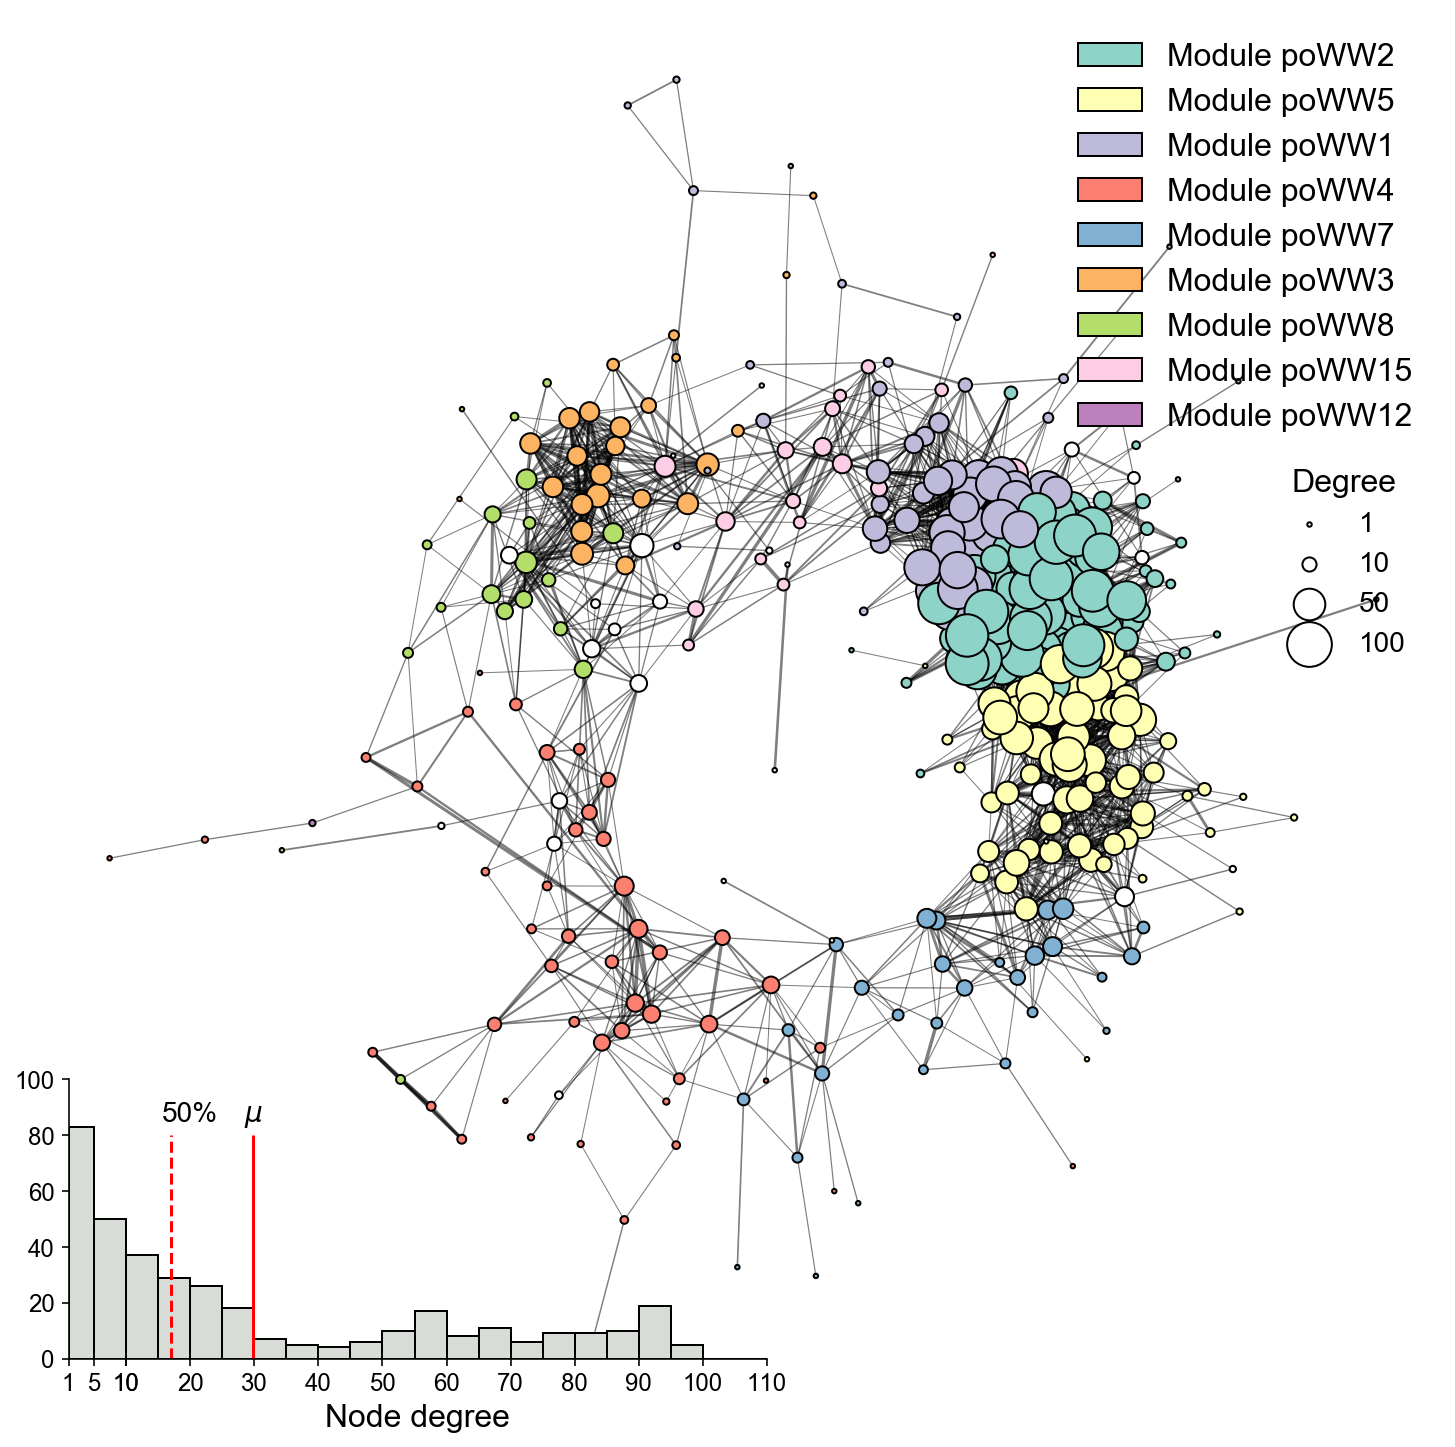

In [15]:
fig, ax = plt.subplots(figsize=(10,10))

pos = nx.kamada_kawai_layout(wwG)

WGCNA_ww_cmap = {}
for idx, (i,v) in enumerate(pathways["WGCNA_ww"].value_counts().items()):
    if idx == 8: idx+=1
    if v>=10:
        color = plt.cm.Set3(idx)
    else:
        color = "xkcd:white"
    WGCNA_ww_cmap[i] = color
    
nodecolors = [WGCNA_ww_cmap[pathways[pathways["transcript"]==n]["WGCNA_ww"].values[0]] for n in wwNodes]

ec = nx.draw_networkx_edges(wwG, pos, alpha=0.5, width=[wwG[u][v]['weight']*2 for u,v in wwG.edges()])
nc = nx.draw_networkx_nodes(wwG, pos, nodelist = wwNodes, node_size=[v*5 for v in ww_degreedict.values()], node_color = nodecolors)
nc.set_edgecolor('black')

handles = []
for i, (k,v) in enumerate(WGCNA_ww_cmap.items()):
    if v == "xkcd:white": continue
    handles.append(mpatches.Patch(color=v, label="Module poWW{}".format(int(k)), ec="black"))
plt.legend(handles=handles, loc="upper right", frameon=False, fontsize=16, ncol=1)

# Point size legend
axpsl = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.9, 0.6, 0.1, 0.1), bbox_transform=ax.transAxes)
axpsl.patch.set_facecolor("None")
l1 = axpsl.scatter([],[], s=5*1, c="white", edgecolors='black', label="1")
l2 = axpsl.scatter([],[], s=5*10, c="white", edgecolors='black', label="10")
l3 = axpsl.scatter([],[], s=5*50, c="white", edgecolors='black', label="50")
l4 = axpsl.scatter([],[], s=5*100, c="white", edgecolors='black', label="100")
axpsl.legend(title="Degree", fontsize="14", frameon=False, title_fontsize=16)
axpsl.axis("off")

# Add inset
axins = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.01, 0.03, 0.5, 0.2), bbox_transform=ax.transAxes, loc=3)
axins.patch.set_facecolor("None")
axins.hist(ww_degreedict.values(), bins=flatten([[0,1,5,10], np.arange(10,150,5)]), color="xkcd:light gray", edgecolor="black")
axins.vlines(x=pathways["wwDegree"].mean(), ymin=0, ymax=80, color='red', linestyles="-")
axins.vlines(x=pathways["wwDegree"].describe()["50%"], ymin=0, ymax=80, color='red', linestyles="--")
axins.text(s="$\mu$", x=pathways["wwDegree"].mean(), y=85, ha='center', size=14)
axins.text(s="50%", x=pathways["wwDegree"].describe()["50%"]+3, y=85, ha='center', size=14)

axins.set_xticks(np.concatenate([[1,5,10], np.arange(10,120,10)]))
axins.set_xticklabels(np.concatenate([[1,5,10], np.arange(10,120,10)]), size=12)
axins.set_yticks(np.arange(0,120,20))
axins.set_yticklabels(np.arange(0,120,20), size=12)
axins.set_xlabel("Node degree", size=16)

# Hide the right and top spines
axins.spines['right'].set_visible(False)
axins.spines['top'].set_visible(False)
axins.set_xlim(1,110)
# axins.set_ylim(0,60)

ax.axis('off')
plt.tight_layout()
# plt.savefig("../Figures/Network-Analysis/P-oleracea-WW-PGN.pdf", transparent=True, bbox_to_inches="tight", dpi=300)

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


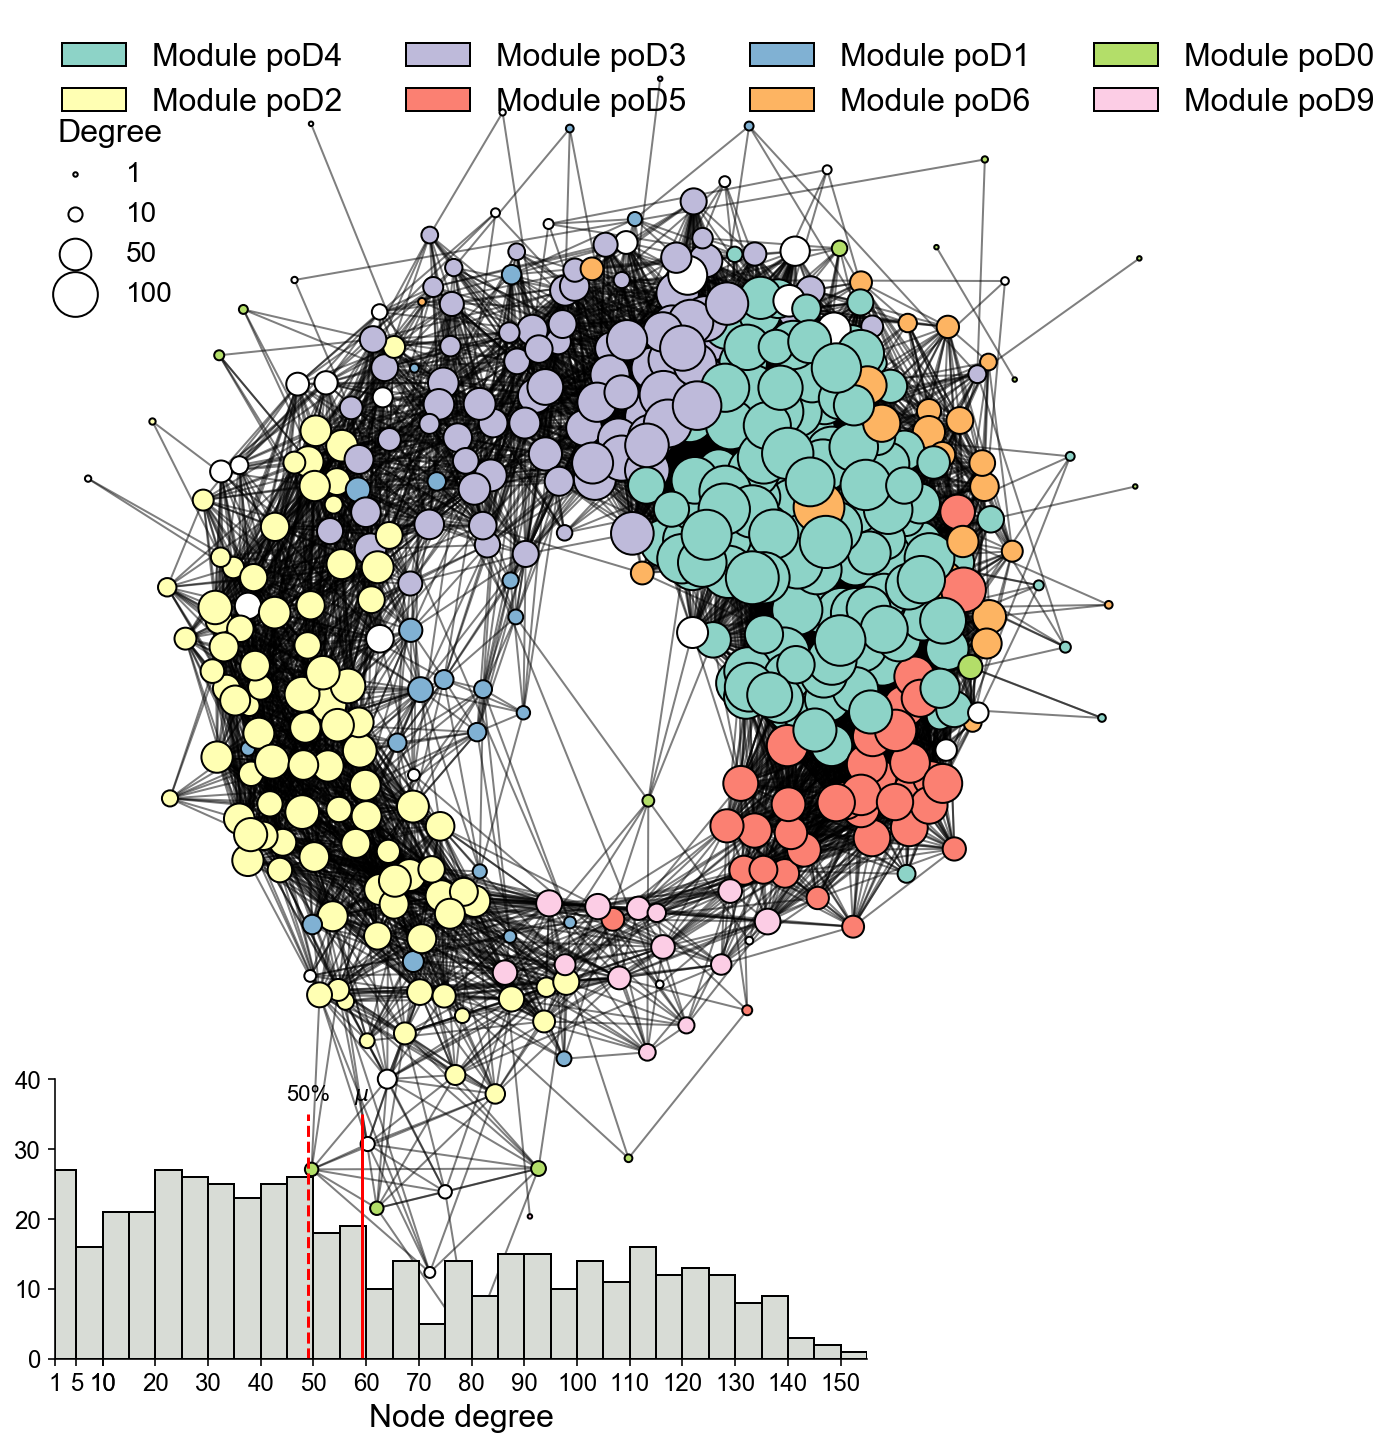

In [16]:
fig, ax = plt.subplots(figsize=(10,10))

pos = nx.kamada_kawai_layout(dG)

WGCNA_d_cmap = {}
for idx, (i,v) in enumerate(pathways["WGCNA_d"].value_counts().items()):
    if idx == 8: idx+=1
    if v>=10:
        color = plt.cm.Set3(idx)
    else:
        color = "xkcd:white"
    WGCNA_d_cmap[i] = color

nodecolors = [WGCNA_d_cmap[pathways[pathways["transcript"]==n]["WGCNA_d"].values[0]] for n in dNodes]
ec = nx.draw_networkx_edges(dG, pos, alpha=0.5, ax=ax)
nc = nx.draw_networkx_nodes(dG, pos, nodelist = dNodes, node_size=[v * 5 for v in d_degreedict.values()], node_color = nodecolors, ax=ax)
nc.set_edgecolor('black')

handles = []
for i, (k,v) in enumerate(WGCNA_d_cmap.items()):
    if v == "xkcd:white": continue
    handles.append(mpatches.Patch(color=v, label="Module poD{}".format(int(k)), ec="black"))
plt.legend(handles=handles, loc="upper left", frameon=False, fontsize=16, ncol=4)

# Point size legend
axpsl = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.05, 0.85, 0.1, 0.1), bbox_transform=ax.transAxes)
axpsl.patch.set_facecolor("None")
l1 = axpsl.scatter([],[], s=5*1, c="white", edgecolors='black', label="1")
l2 = axpsl.scatter([],[], s=5*10, c="white", edgecolors='black', label="10")
l3 = axpsl.scatter([],[], s=5*50, c="white", edgecolors='black', label="50")
l4 = axpsl.scatter([],[], s=5*100, c="white", edgecolors='black', label="100")
axpsl.legend(title="Degree", fontsize="14", frameon=False, title_fontsize=16)
axpsl.axis("off")

# Add inset
axins = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.01, 0.03, 0.7, 0.2), bbox_transform=ax.transAxes, loc=3)
axins.patch.set_facecolor("None")
axins.hist(d_degreedict.values(), bins=flatten([[0,1,5,10], np.arange(10,160,5)]), color="xkcd:light gray", edgecolor="black")
axins.vlines(x=pathways["dDegree"].mean(), ymin=0, ymax=35, color='red', linestyles="-")
axins.vlines(x=pathways["dDegree"].describe()["50%"], ymin=0, ymax=35, color='red', linestyles="--")
axins.text(s="$\mu$", x=pathways["dDegree"].mean(), y=37, ha='center', size=11)
axins.text(s="50%", x=pathways["dDegree"].describe()["50%"], y=37, ha='center', size=11)

axins.set_xticks(np.concatenate([[1,5,10], np.arange(10,180,10)]))
axins.set_xticklabels(np.concatenate([[1,5,10], np.arange(10,180,10)]), size=12)
axins.set_yticks(np.arange(0,60,10))
axins.set_yticklabels(np.arange(0,60,10), size=12)
axins.set_xlabel("Node degree", size=16)
# Hide the right and top spines
axins.spines['right'].set_visible(False)
axins.spines['top'].set_visible(False)
axins.set_xlim(1,155)
axins.set_ylim(0,40)

ax.axis('off')
plt.tight_layout()
# plt.savefig("../Figures/Network-Analysis/P-oleracea-D-PGN.pdf", transparent=True, bbox_to_inches="tight", dpi=300)

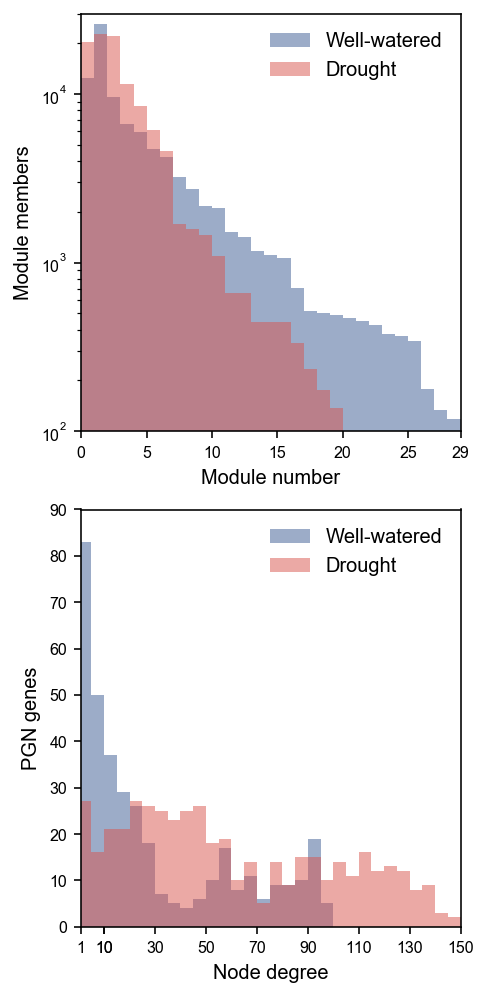

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(3.5, 7))

bins = np.arange(0,np.max(wwModAssgn[["WGCNA_ww", "WGCNA_d"]].max().values)+2,1)
ax[0].hist(wwModAssgn["WGCNA_ww"], bins=bins, color = "xkcd:denim blue", alpha=0.5, label="Well-watered")
ax[0].hist(wwModAssgn['WGCNA_d'], bins=bins, color = "xkcd:pale red", alpha=0.5, label = "Drought")
ax[0].legend(frameon=False, fontsize=10)

ax[0].set_xticks(np.concatenate([np.arange(0, bins[-1]+1, 5), [29]]))
ax[0].set_xticklabels(["{}".format(int(t)) for t in np.concatenate([np.arange(0, bins[-1]+1, 5), [29]])], size=8)
ax[0].set_yticks(np.arange(0, 12000, 1000))
ax[0].set_yticklabels(np.arange(0, 12000, 1000), size=8)
ax[0].set_xlim(0,29)
ax[0].set_xlabel("Module number", size=10)
ax[0].set_ylabel("Module members", size=10)
ax[0].semilogy()
ax[0].set_ylim(100,30000)
        
# Add inset
bins=flatten([[0,1,5,10], np.arange(10,165,5)])
ax[1].hist(ww_degreedict.values(), bins=bins, color = "xkcd:denim blue", alpha=0.5, label="Well-watered")
ax[1].hist(d_degreedict.values(), bins=bins, color = "xkcd:pale red", alpha=0.5, label="Drought")
ax[1].legend(frameon=False, fontsize=10)

ax[1].set_xticks(np.concatenate([[1,10], np.arange(10,160,20)]))
ax[1].set_xticklabels(np.concatenate([[1,10], np.arange(10,160,20)]), size=8)
ax[1].set_yticks(np.arange(0,100,10))
ax[1].set_yticklabels(np.arange(0,100,10), size=8)
ax[1].set_xlabel("Node degree", size=10)
ax[1].set_ylabel("PGN genes", size=10)
ax[1].set_xlim(1,150)
ax[1].set_ylim(0,90)

plt.tight_layout()
plt.savefig("../Figures/Network-Analysis/P-oleracea-FigureS1.pdf", transparent=True, bbox_to_inches="tight", dpi=300)

In [18]:
pathways = pathways.fillna('')

In [19]:
pathways[pathways["Pamilis-uniprot"].str.startswith("PPC-1E1a")]

transcript Orthogroup Athaliana-ortholog Pamilis-ortholog  \
333   TRINITY_DN1747_c2_g1                                     FUN_020790   
334  TRINITY_DN22457_c0_g1                                     FUN_020790   
335  TRINITY_DN22457_c0_g2                                     FUN_020790   
336  TRINITY_DN22457_c0_g3                                     FUN_020790   
338   TRINITY_DN3235_c0_g2                                                  
341  TRINITY_DN61415_c0_g3                                                  
346   TRINITY_DN7279_c1_g1                                                  
347   TRINITY_DN7540_c2_g2                                                  
351  TRINITY_DN82675_c2_g1                                     FUN_020790   

    Pamilis-uniprot Gene-family                  Block-description  \
333       PPC-1E1a'         PPC  Phosphoenolpyruvate carboxylase 1   
334       PPC-1E1a'         PPC  Phosphoenolpyruvate carboxylase 1   
335       PPC-1E1a'         PPC  Phosphoenolpyruvate carboxylase 1   
336       PPC-1E1a'         PPC  Phosphoenolpyruvate carboxylase 1   
338        PPC-1E1a         PPC  Phosphoenolpyruvate carboxylase 1   
341        PPC-1E1a         PPC  Phosphoenolpyruvate carboxylase 1   
346        PPC-1E1a         PPC  Phosphoenolpyruvate carboxylase 1   
347        PPC-1E1a         PPC  Phosphoenolpyruvate carboxylase 1   
351       PPC-1E1a'         PPC  Phosphoenolpyruvate carboxylase 1   

           Pathway Athaliana-uniprot Poleracea-uniprot Localization  \
333  Carboxylation                                                    
334  Carboxylation                                                    
335  Carboxylation                                                    
336  Carboxylation                                                    
338  Carboxylation                                                    
341  Carboxylation                                                    
346  Carboxylation                                                    
347  Carboxylation                                                    
351  Carboxylation                                                    

             qval    Uniprot  WGCNA_ww  WGCNA_d wwDegree dDegree  \
333  1.332394e-15  PPC-1E1a'       2.0      4.0       96     131   
334  5.073692e-06  PPC-1E1a'       2.0      4.0       92     102   
335  5.066249e-05  PPC-1E1a'       1.0      4.0       79      93   
336  9.021005e-05  PPC-1E1a'       2.0      4.0       57      35   
338  2.191672e-01   PPC-1E1a       4.0      4.0       18     126   
341  5.174078e-04   PPC-1E1a       4.0      4.0       15       6   
346  6.437952e-03   PPC-1E1a       4.0      4.0       16      92   
347  5.825980e-04   PPC-1E1a       4.0      1.0       15       4   
351  3.001875e-05  PPC-1E1a'       2.0      4.0       76     111   

         pathway_color  
333  xkcd:bright green  
334  xkcd:bright green  
335  xkcd:bright green  
336  xkcd:bright green  
338  xkcd:bright green  
341  xkcd:bright green  
346  xkcd:bright green  
347  xkcd:bright green  
351  xkcd:bright green

The picture here is not as clear as in _P. amilis_. The PPC-1E1c fall into three drought modules that all peak over the day-night transition, but PoD2 has its greatest rise from time points 2-3, while poD9 increases from 1-2 and then mostly plateaus over 2-3, and poD5 peaks at time point 2 and decreases from 2-3. With more transcripts to cluster, we were perhaps able to put a a finer resolution on temporal dynamics.

We also see that 1E1a and 1E1a' have consistently different behavior when well-watered, but then synchronize under drought. All but 1 copy of 1E1a' is in the largest (presumably C4) module (poWW2) and all transition to poD4. In this case, a C4 module remains the largest module under drought, but the pattern of expression changes to be less exagerated in the morning.

As in the _P. amilis_ analysis, I'll take a look at the overlap between a few key sets of genes.

In [21]:
c_watered = pathways[pathways["WGCNA_ww"].isin([4,8])]
c_drought = pathways[pathways["WGCNA_d"].isin([2,5,9])]
aprime_watered = pathways[pathways["WGCNA_ww"].isin([1,2])]
aprime_drought = pathways[pathways["WGCNA_d"]==4]
C4_watered = pathways[pathways["WGCNA_ww"].isin([1,2])]
C4_drought = pathways[pathways["WGCNA_d"].isin([3,4])]

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


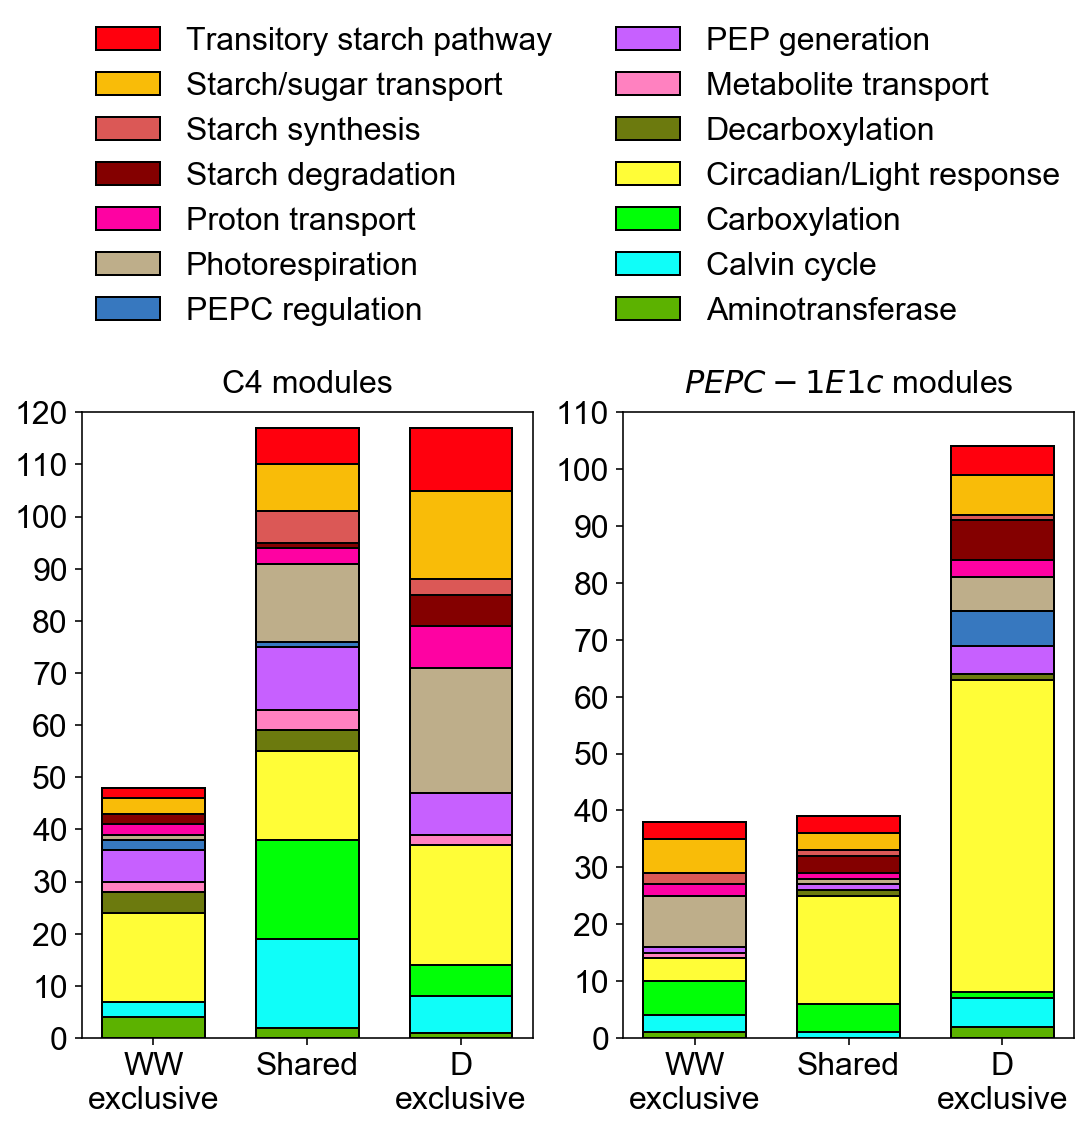

In [22]:
fig = plt.figure(constrained_layout=True, figsize=(8,8))
gs = fig.add_gridspec(3,2)
leg_ax = fig.add_subplot(gs[0,:])
axL = fig.add_subplot(gs[1:,0])
axR = fig.add_subplot(gs[1:,1])

# Left
purple_bottom = 0
for k,v in pathways[pathways["transcript"].isin(set(C4_watered.transcript).difference(C4_drought.transcript))]["Pathway"].value_counts(sort=False).sort_index().iteritems():
    axL.bar(x=0, height=v, bottom=purple_bottom, color = colormap[k], edgecolor="black", width=0.5)
    purple_bottom+=v

purple_blue_bottom = 0
for k,v in pathways[pathways["transcript"].isin(set(C4_watered.transcript).intersection(C4_drought.transcript))]["Pathway"].value_counts(sort=False).sort_index().iteritems():
    axL.bar(x=0.75, height=v, bottom=purple_blue_bottom, color = colormap[k], edgecolor="black", width=0.5)
    purple_blue_bottom+=v
    
blue_bottom = 0
for k,v in pathways[pathways["transcript"].isin(set(C4_drought.transcript).difference(C4_watered.transcript))]["Pathway"].value_counts(sort=False).sort_index().iteritems():
    axL.bar(x=1.5, height=v, bottom=blue_bottom, color = colormap[k], edgecolor="black", width=0.5)
    blue_bottom+=v

# Right
purple_bottom = 0
for k,v in pathways[pathways["transcript"].isin(set(c_watered.transcript).difference(c_drought.transcript))]["Pathway"].value_counts(sort=False).sort_index().iteritems():
    axR.bar(x=0, height=v, bottom=purple_bottom, color = colormap[k], edgecolor="black", width=0.5)
    purple_bottom+=v

purple_blue_bottom = 0
for k,v in pathways[pathways["transcript"].isin(set(c_watered.transcript).intersection(c_drought.transcript))]["Pathway"].value_counts(sort=False).sort_index().iteritems():
    axR.bar(x=0.75, height=v, bottom=purple_blue_bottom, color = colormap[k], edgecolor="black", width=0.5)
    purple_blue_bottom+=v
    
blue_bottom = 0
for k,v in pathways[pathways["transcript"].isin(set(c_drought.transcript).difference(c_watered.transcript))]["Pathway"].value_counts(sort=False).sort_index().iteritems():
    axR.bar(x=1.5, height=v, bottom=blue_bottom, color = colormap[k], edgecolor="black", width=0.5)
    blue_bottom+=v
    
handles = []
for i, (k,v) in enumerate(sorted(colormap.items(), reverse=True)):
    if k == "Circadian rhythm/Light response": k = "Circadian rhythm/\nLight response"
    handles.append(mpatches.Patch(color=v, label=k, ec="black"))
leg_ax.legend(handles=handles, loc="center", frameon=False, fontsize=16, ncol=2)
leg_ax.axis("off")

for ax in [axL,axR]:
    ax.set_xticks([0,0.75,1.5])
    ax.set_xticklabels(["WW\nexclusive", "Shared", "D\nexclusive"], rotation=0, size=16)
    
axL.set_yticks(np.arange(0,130,10))
axL.set_yticklabels(np.arange(0,130,10), size=16)
axL.set_ylim(0,120)
axR.set_yticks(np.arange(0,120,10))
axR.set_yticklabels(np.arange(0,120,10), size=16)

axL.set_title("C4 modules", size=16, pad=10)
axR.set_title("$PEPC-1E1c$ modules", size=16, pad=10)

plt.tight_layout()
# plt.savefig("../Figures/Network-Analysis/P-oleracea-PEPC-module-intersections.pdf", bbox_to_inches="tight", dpi=300)

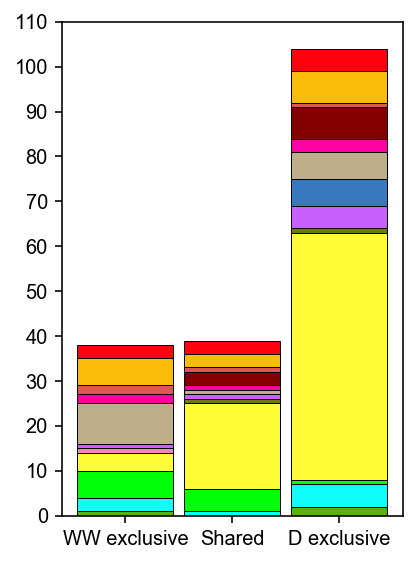

In [23]:
fig, axR = plt.subplots(figsize=(3,4))

# Right
purple_bottom = 0
for k,v in pathways[pathways["transcript"].isin(set(c_watered.transcript).difference(c_drought.transcript))]["Pathway"].value_counts(sort=False).sort_index().iteritems():
    axR.bar(x=0, height=v, bottom=purple_bottom, color = colormap[k], edgecolor="black", width=0.45, linewidth=0.5)
    purple_bottom+=v

purple_blue_bottom = 0
for k,v in pathways[pathways["transcript"].isin(set(c_watered.transcript).intersection(c_drought.transcript))]["Pathway"].value_counts(sort=False).sort_index().iteritems():
    axR.bar(x=0.5, height=v, bottom=purple_blue_bottom, color = colormap[k], edgecolor="black", width=0.45, linewidth=0.5)
    purple_blue_bottom+=v
    
blue_bottom = 0
for k,v in pathways[pathways["transcript"].isin(set(c_drought.transcript).difference(c_watered.transcript))]["Pathway"].value_counts(sort=False).sort_index().iteritems():
    axR.bar(x=1., height=v, bottom=blue_bottom, color = colormap[k], edgecolor="black", width=0.45, linewidth=0.5)
    blue_bottom+=v

axR.set_xticks([0,0.5,1])
axR.set_xticklabels(["WW exclusive", "Shared", "D exclusive"], rotation=0, size=10)
axR.set_yticks(np.arange(0,120,10))
axR.set_yticklabels(np.arange(0,120,10), size=10)
axR.set_ylim(0,110)

plt.tight_layout()
# plt.savefig("../Figures/Network-Analysis/P-oleracea-PPC-1E1c-intersections.pdf", bbox_to_inches="tight", dpi=300)

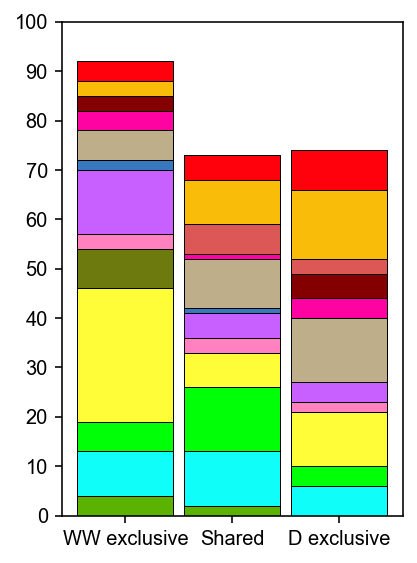

In [24]:
fig, axR = plt.subplots(figsize=(3,4))

# Right
purple_bottom = 0
for k,v in pathways[pathways["transcript"].isin(set(aprime_watered.transcript).difference(aprime_drought.transcript))]["Pathway"].value_counts(sort=False).sort_index().iteritems():
    axR.bar(x=0, height=v, bottom=purple_bottom, color = colormap[k], edgecolor="black", width=0.45, linewidth=0.5)
    purple_bottom+=v

purple_blue_bottom = 0
for k,v in pathways[pathways["transcript"].isin(set(aprime_watered.transcript).intersection(aprime_drought.transcript))]["Pathway"].value_counts(sort=False).sort_index().iteritems():
    axR.bar(x=0.5, height=v, bottom=purple_blue_bottom, color = colormap[k], edgecolor="black", width=0.45, linewidth=0.5)
    purple_blue_bottom+=v
    
blue_bottom = 0
for k,v in pathways[pathways["transcript"].isin(set(aprime_drought.transcript).difference(aprime_watered.transcript))]["Pathway"].value_counts(sort=False).sort_index().iteritems():
    axR.bar(x=1., height=v, bottom=blue_bottom, color = colormap[k], edgecolor="black", width=0.45, linewidth=0.5)
    blue_bottom+=v

axR.set_xticks([0,0.5,1])
axR.set_xticklabels(["WW exclusive", "Shared", "D exclusive"], rotation=0, size=10)
axR.set_yticks(np.arange(0,120,10))
axR.set_yticklabels(np.arange(0,120,10), size=10)
axR.set_ylim(0,100)

plt.tight_layout()
# plt.savefig("../Figures/Network-Analysis/P-oleracea-PPC-1E1a'-intersections.pdf", bbox_to_inches="tight", dpi=300)

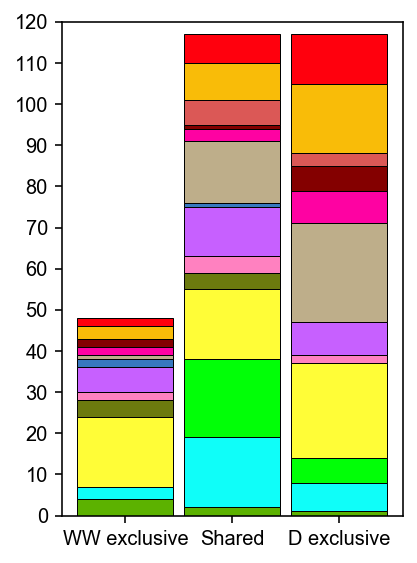

In [25]:
fig, axL = plt.subplots(figsize=(3,4))

# left
purple_bottom = 0
for k,v in pathways[pathways["transcript"].isin(set(C4_watered.transcript).difference(C4_drought.transcript))]["Pathway"].value_counts(sort=False).sort_index().iteritems():
    axL.bar(x=0, height=v, bottom=purple_bottom, color = colormap[k], edgecolor="black", width=0.45, linewidth=0.5)
    purple_bottom+=v

purple_blue_bottom = 0
for k,v in pathways[pathways["transcript"].isin(set(C4_watered.transcript).intersection(C4_drought.transcript))]["Pathway"].value_counts(sort=False).sort_index().iteritems():
    axL.bar(x=0.5, height=v, bottom=purple_blue_bottom, color = colormap[k], edgecolor="black", width=0.45, linewidth=0.5)
    purple_blue_bottom+=v
    
blue_bottom = 0
for k,v in pathways[pathways["transcript"].isin(set(C4_drought.transcript).difference(C4_watered.transcript))]["Pathway"].value_counts(sort=False).sort_index().iteritems():
    axL.bar(x=1., height=v, bottom=blue_bottom, color = colormap[k], edgecolor="black", width=0.45, linewidth=0.5)
    blue_bottom+=v

axL.set_xticks([0,0.5,1])
axL.set_xticklabels(["WW exclusive", "Shared", "D exclusive"], rotation=0, size=10)
axL.set_yticks(np.arange(0,130,10))
axL.set_yticklabels(np.arange(0,130,10), size=10)
axL.set_ylim(0,120)

plt.tight_layout()
# plt.savefig("../Figures/Network-Analysis/P-oleracea-WWC4-intersections.pdf", bbox_to_inches="tight", dpi=300)

In [27]:
print(len(pathways[pathways["transcript"].isin(set(C4_watered.transcript).intersection(C4_drought.transcript))]))
print(len(pathways[pathways["transcript"].isin(set(C4_watered.transcript).intersection(C4_drought.transcript))])/len(pathways[pathways["transcript"].isin(set(C4_watered.transcript).union(C4_drought.transcript))]))

117
0.4148936170212766


In [28]:
len(C4_watered)

165

## _P. oleracea_ drought exclusive C4 PGN

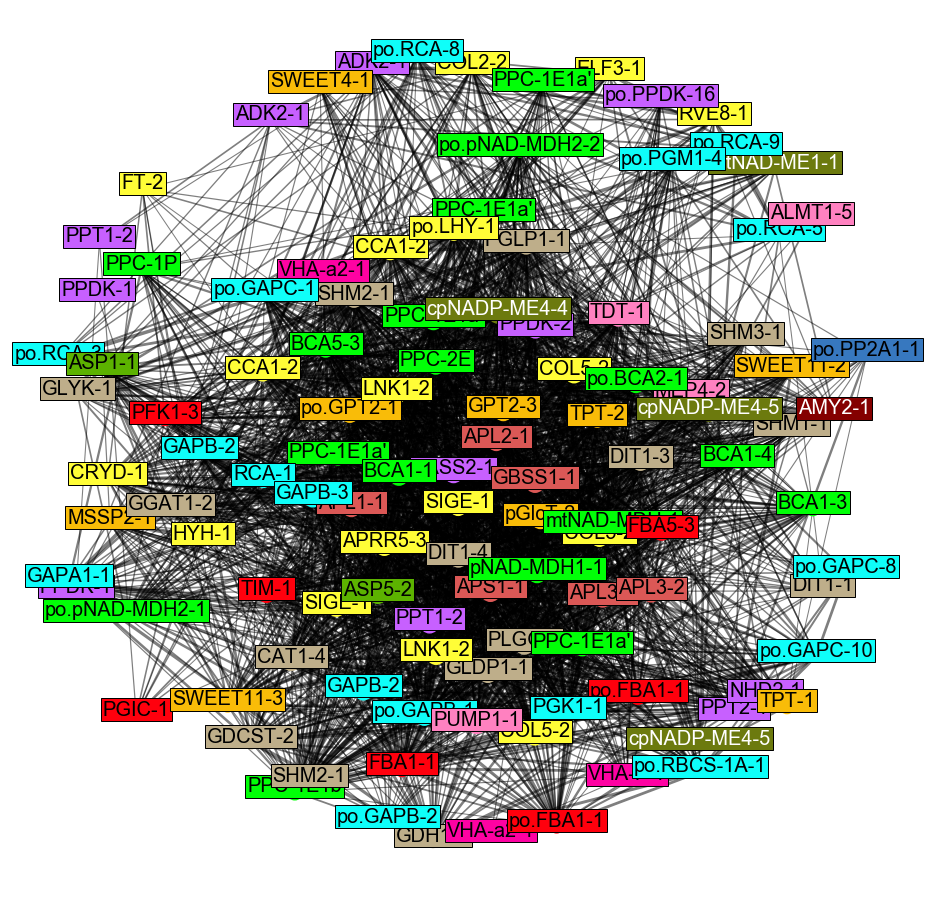

In [30]:
graph = remove_singletons(dG.subgraph(pathways[(pathways["WGCNA_ww"].isin([1,2]) & pathways["WGCNA_d"].isin([3,4]))].transcript.values))
degreedict = dict(graph.degree(graph.nodes))

fig, ax = plt.subplots(figsize=(8,8))
pos = nx.spring_layout(graph, k=3, iterations=100)
nodecolors = [colormap[pathways[pathways["transcript"]==n]["Pathway"].values[0]] for n in graph.nodes]

ec = nx.draw_networkx_edges(graph, pos, alpha=0.5, width=[graph[u][v]['weight']*2 for u,v in graph.edges()])
nc = nx.draw_networkx_nodes(graph, pos, nodelist = graph.nodes, node_size=[v for v in degreedict.values()], 
                        node_color = nodecolors, label=pathways[pathways["transcript"].isin(list(graph.nodes))]["Pathway"].values)

for m,(x,y) in pos.items():
    label = str(pathways[pathways['transcript']==m]["Uniprot"].values[0])
    color = colormap[pathways[pathways['transcript']==m]["Pathway"].values[0]]
    edgecolor = WGCNA_d_cmap[pathways[pathways['transcript']==m]["WGCNA_d"].values[0]]
    if color in ["xkcd:strong blue", "xkcd:dark red", "xkcd:blue violet", "xkcd:murky green"]: 
        fontcolor = "white"
    else:
        fontcolor = "black"
    ax.text(x, y, s=label, bbox=dict(facecolor=color, alpha=1, edgecolor='black', linewidth=0.5, pad=1), 
            horizontalalignment='center', fontdict={"color":fontcolor}, size=10)

ax.axis('off');
# plt.savefig("../Figures/Network-Analysis/P-oleracea-drought-exclusive-C4.pdf", format="pdf", dpi=300, bbox_to_inches="tight")

## _P. amilis_ drought _PPC-1E1c_ PGN

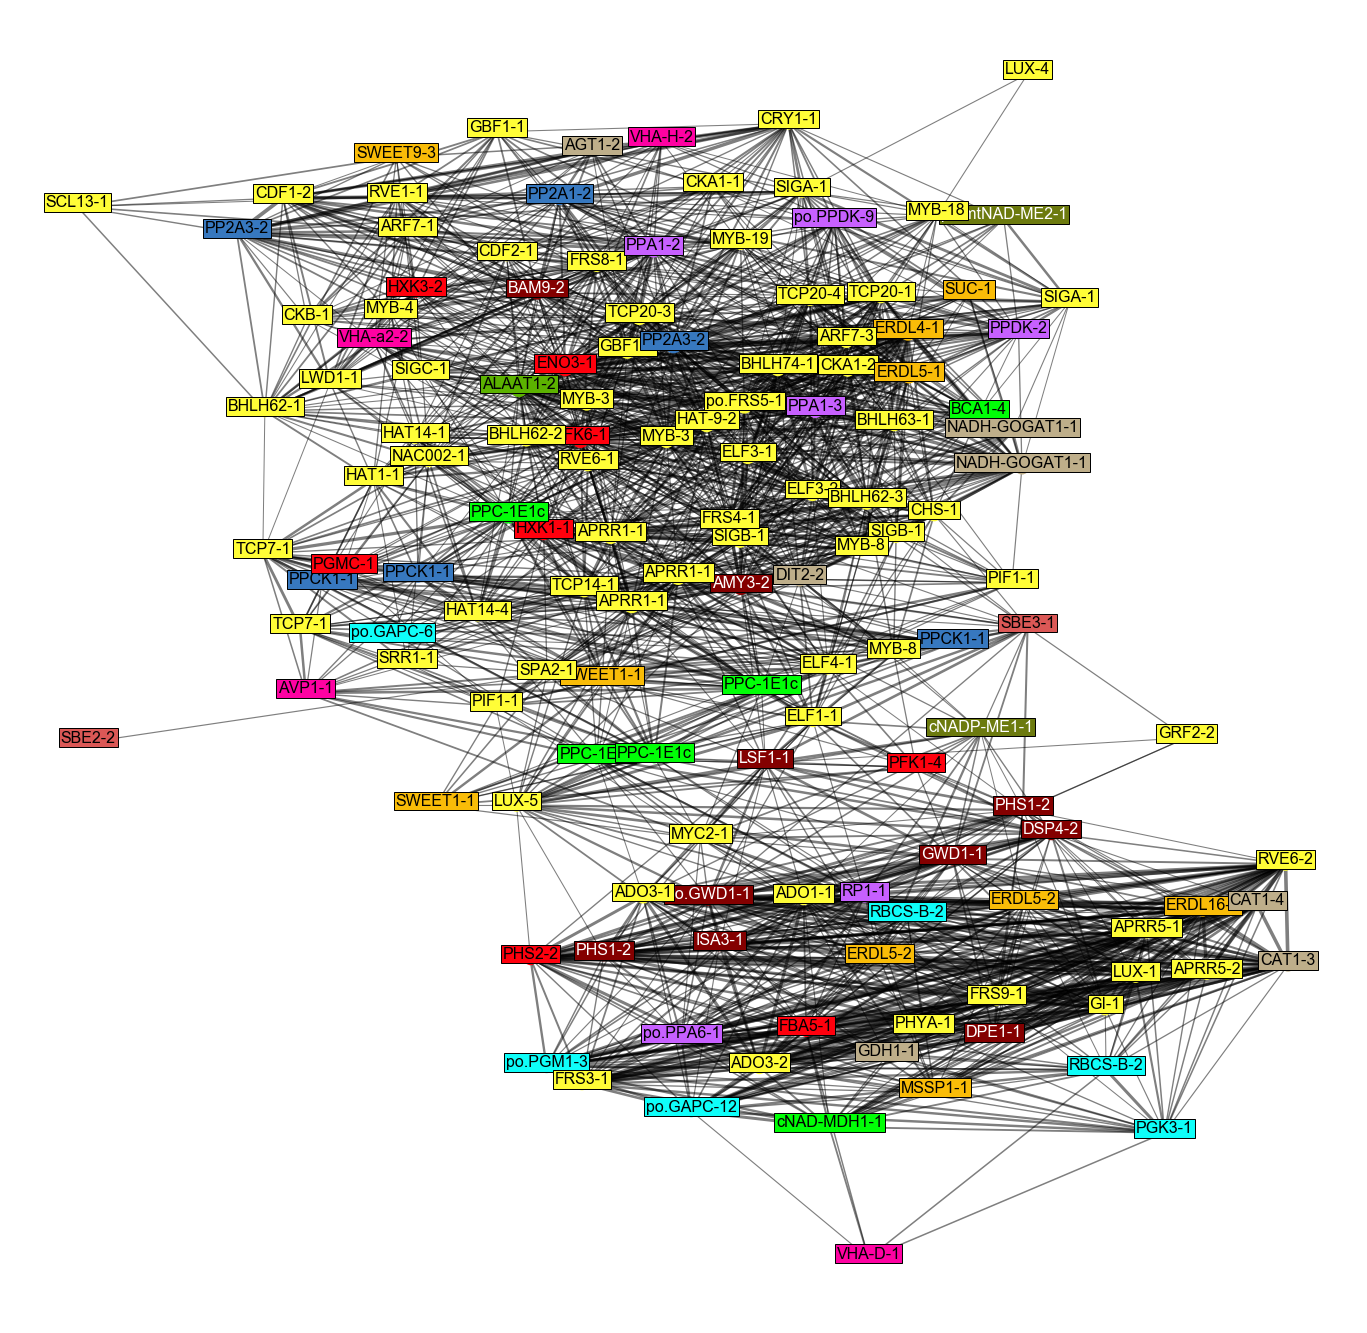

In [26]:
graph = remove_singletons(dG.subgraph(c_drought.transcript.values))
degreedict = dict(graph.degree(graph.nodes))

fig, ax = plt.subplots(figsize=(12,12))
pos = nx.kamada_kawai_layout(graph)
nodecolors = [colormap[pathways[pathways["transcript"]==n]["Pathway"].values[0]] for n in graph.nodes]

ec = nx.draw_networkx_edges(graph, pos, alpha=0.5, width=[graph[u][v]['weight']*2 for u,v in graph.edges()])
nc = nx.draw_networkx_nodes(graph, pos, nodelist = graph.nodes, node_size=[v for v in degreedict.values()], 
                        node_color = nodecolors, label=pathways[pathways["transcript"].isin(list(graph.nodes))]["Pathway"].values)

for m,(x,y) in pos.items():
    label = str(pathways[pathways['transcript']==m]["Uniprot"].values[0])
    color = colormap[pathways[pathways['transcript']==m]["Pathway"].values[0]]
    edgecolor = WGCNA_d_cmap[pathways[pathways['transcript']==m]["WGCNA_d"].values[0]]
    if color in ["xkcd:strong blue", "xkcd:dark red", "xkcd:blue violet", "xkcd:murky green"]: 
        fontcolor = "white"
    else:
        fontcolor = "black"
    ax.text(x, y, s=label, bbox=dict(facecolor=color, alpha=1, edgecolor='black', linewidth=0.5, pad=1), 
            horizontalalignment='center', fontdict={"color":fontcolor}, size=8)

ax.axis('off');
# plt.savefig("../Figures/Network-Analysis/P-oleracea-PPC-1E1c-drought.pdf", format="pdf", dpi=300, bbox_to_inches="tight")

## _P. oleracea_ drought exclusive _PPC-1E1c_ PGN

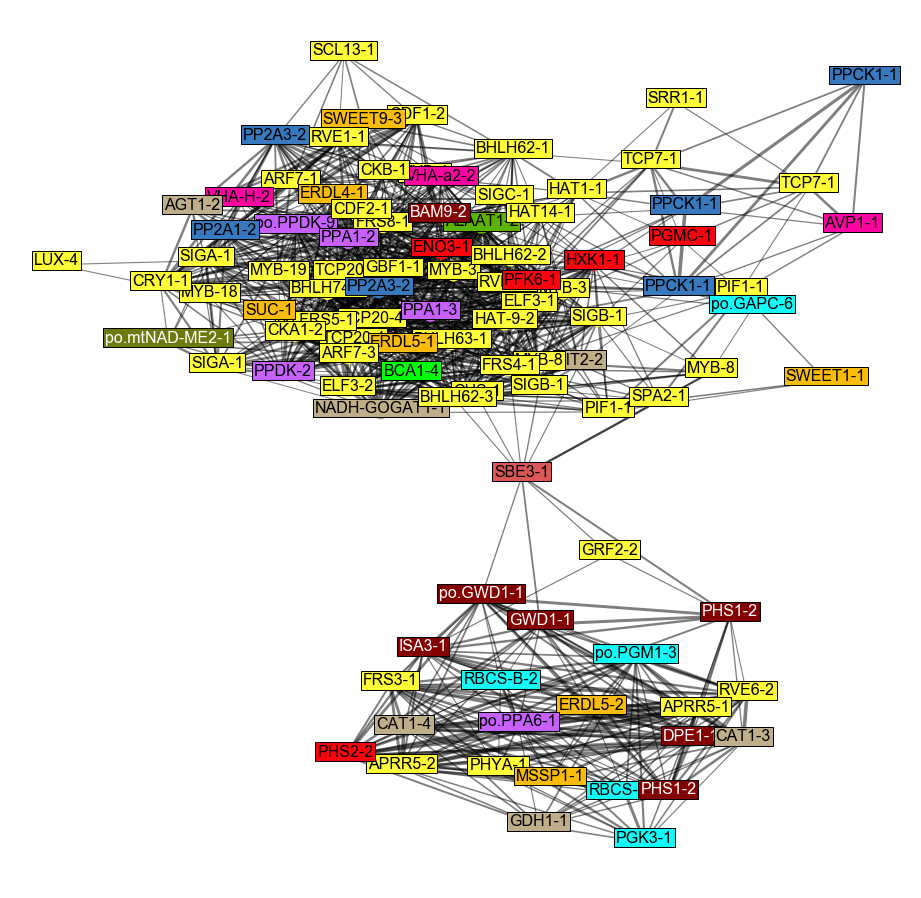

In [27]:
graph = remove_singletons(dG.subgraph(set(c_drought.transcript.values).difference(set(c_watered.transcript.values))))
degreedict = dict(graph.degree(graph.nodes))

fig, ax = plt.subplots(figsize=(8,8))
pos = nx.kamada_kawai_layout(graph,)
nodecolors = [colormap[pathways[pathways["transcript"]==n]["Pathway"].values[0]] for n in graph.nodes]

ec = nx.draw_networkx_edges(graph, pos, alpha=0.5, width=[graph[u][v]['weight']*2 for u,v in graph.edges()])
nc = nx.draw_networkx_nodes(graph, pos, nodelist = graph.nodes, node_size=[v for v in degreedict.values()], 
                        node_color = nodecolors, label=pathways[pathways["transcript"].isin(list(graph.nodes))]["Pathway"].values)

for m,(x,y) in pos.items():
    label = str(pathways[pathways['transcript']==m]["Uniprot"].values[0])
    color = colormap[pathways[pathways['transcript']==m]["Pathway"].values[0]]
    edgecolor = WGCNA_d_cmap[pathways[pathways['transcript']==m]["WGCNA_d"].values[0]]
    if color in ["xkcd:strong blue", "xkcd:dark red", "xkcd:blue violet", "xkcd:murky green"]: 
        fontcolor = "white"
    else:
        fontcolor = "black"
    ax.text(x, y, s=label, bbox=dict(facecolor=color, alpha=1, edgecolor='black', linewidth=0.5, pad=1), 
            horizontalalignment='center', fontdict={"color":fontcolor}, size=8)

ax.axis('off');
# plt.savefig("../Figures/Network-Analysis/P-oleracea-PPC-1E1c-drought-exclusive.pdf", format="pdf", dpi=300, bbox_to_inches="tight")

## Combining plots

In [28]:
sleuth_all = pd.read_csv("../Abundance-analysis/sleuth/P-oleracea-unigenes-TPM-with-metadata.csv", index_col=0)
sleuth = sleuth_all[sleuth_all["unigene"].isin(pathways['transcript'])]
del sleuth_all
sleuth = sleuth.rename({"unigene":"transcript"}, axis=1)
sleuth = sleuth.merge(pathways).drop(labels=["RNA_No", "Collection_time", "Acc_No", "color", "hex_color", "sequencer_name"], axis=1)

watered_grouped = sleuth[sleuth["time_point"]<4].groupby(["time_point", "transcript"]).describe()["tpm"]
watered_grouped = watered_grouped.reset_index()

drought_grouped = sleuth[sleuth["time_point"]>=4].groupby(["time_point", "transcript"]).describe()["tpm"]
drought_grouped = drought_grouped.reset_index()

watered_pivot = watered_grouped.pivot(index="transcript", columns="time_point", values="50%")
drought_pivot = drought_grouped.pivot(index="transcript", columns="time_point", values="50%")

w_X = np.transpose(watered_pivot[[0,1,2,3]].values.copy())
w_X = np.transpose(StandardScaler().fit_transform(w_X))
w_X = pd.DataFrame(w_X, index=watered_pivot.index, columns=[0,1,2,3]).reset_index().merge(pathways[["transcript", "Pathway",'WGCNA_ww',"WGCNA_d"]], on="transcript")

d_X = np.transpose(drought_pivot[[4,5,6,7]].values.copy())
d_X = np.transpose(StandardScaler().fit_transform(d_X))
d_X = pd.DataFrame(d_X, index=drought_pivot.index, columns=[0,1,2,3]).reset_index().merge(pathways[["transcript", "Pathway",'WGCNA_ww',"WGCNA_d"]], on="transcript")

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


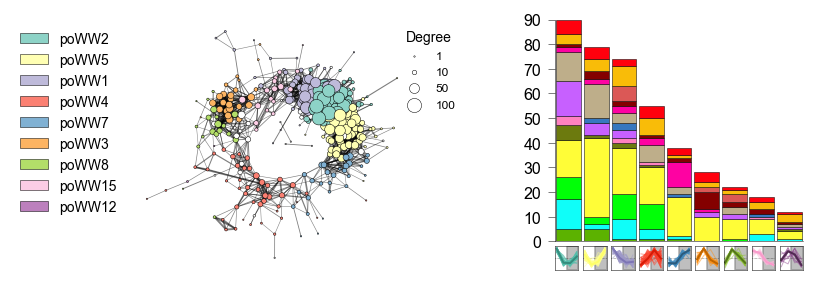

In [30]:
fig = plt.figure(constrained_layout=False, figsize=(6.75, 2.3))

gs = fig.add_gridspec(nrows=9, ncols=27)
ax_nxleg = fig.add_subplot(gs[:,0:3])
ax_nx = fig.add_subplot(gs[:,3:13])
ax_psleg = fig.add_subplot(gs[:, 13:15])
ax_w01 = fig.add_subplot(gs[8, 18])
ax_w02 = fig.add_subplot(gs[8, 19])
ax_w03 = fig.add_subplot(gs[8, 20])
ax_w04 = fig.add_subplot(gs[8, 21])
ax_w05 = fig.add_subplot(gs[8, 22])
ax_w06 = fig.add_subplot(gs[8, 23])
ax_w07 = fig.add_subplot(gs[8, 24])
ax_w08 = fig.add_subplot(gs[8, 25])
ax_w09 = fig.add_subplot(gs[8, 26])
ax_bg = fig.add_subplot(gs[0:-1, 18:])

for i, ax in enumerate(fig.get_axes()):
    ax.set_xticks([])
    ax.set_yticks([])

# Module color legend
handles = []
for i, (k,v) in enumerate(WGCNA_ww_cmap.items()):
    if v == "xkcd:white": continue
    handles.append(mpatches.Patch(color=v, label="poWW{}".format(int(k)), ec="black", linewidth=0.25))
ax_nxleg.legend(handles=handles, loc="upper right", frameon=False, fontsize=7, ncol=1)
ax_nxleg.axis('off')

# Point size legend
l1 = ax_psleg.scatter([],[], s=0.5*1, c="white", edgecolors='black', label="1", linewidth=0.25)
l2 = ax_psleg.scatter([],[], s=0.5*10, c="white", edgecolors='black', label="10", linewidth=0.25)
l3 = ax_psleg.scatter([],[], s=0.5*50, c="white", edgecolors='black', label="50", linewidth=0.25)
l4 = ax_psleg.scatter([],[], s=0.5*100, c="white", edgecolors='black', label="100", linewidth=0.25)
ax_psleg.legend(title="Degree", fontsize="6", frameon=False, title_fontsize=7)
ax_psleg.axis("off")

# Network plot
pos = nx.kamada_kawai_layout(wwG)
WGCNA_ww_cmap = {}
for idx, (i,v) in enumerate(pathways["WGCNA_ww"].value_counts().items()):
    if idx == 8: idx+=1
    if v>=10: color = plt.cm.Set3(idx)
    else: color = "xkcd:white"
    WGCNA_ww_cmap[i] = color
nodecolors = [WGCNA_ww_cmap[pathways[pathways["transcript"]==n]["WGCNA_ww"].values[0]] for n in wwNodes]
ec = nx.draw_networkx_edges(wwG, pos, alpha=0.5, width=[wwG[u][v]['weight'] for u,v in wwG.edges()], ax=ax_nx)
nc = nx.draw_networkx_nodes(wwG, pos, nodelist = wwNodes, node_size=[v/2 for v in ww_degreedict.values()], 
                            node_color = nodecolors, linewidths=0.25, ax=ax_nx)
nc.set_edgecolor('black')
ax_nx.axis('off')

# Bar plot
x=0
for i,v in pathways["WGCNA_ww"].value_counts().items():
    if v>=10:
        bottom = 0
        for k,p in pathways[pathways["WGCNA_ww"]==i]["Pathway"].value_counts(sort=False).sort_index().iteritems():
            ax_bg.bar(x=x, height=p, bottom=bottom, color = colormap[k], edgecolor="black", 
                      width=0.9, align="center", linewidth=0.25)
            bottom+=p
        x+=1
ax_bg.tick_params(axis="y", which='both', width=0.25)        
ax_bg.set_yticks(np.arange(0,120,10))
ax_bg.set_yticklabels(np.arange(0,110,10), size=8)
ax_bg.set_xlim(-0.5,8.5)
ax_bg.set_ylim(0,90)
for a in ['bottom','left']: ax_bg.spines[a].set_linewidth(0.25)
for a in ['top','right']: ax_bg.spines[a].set_linewidth(0)

# Z-score plots
for ax,(k,c) in zip([ax_w01,ax_w02,ax_w03,ax_w04,ax_w05,ax_w06,ax_w07,ax_w08,ax_w09],WGCNA_ww_cmap.items()):
    if c == "xkcd:white":
        continue
    else:
        rect = mpatches.Rectangle(xy=(1.5, -2), width=1.75, height=4, color='grey', alpha=0.5)
        ax.add_patch(rect)
        ax.set_xlim(-0.25,3.25)
        ax.set_ylim(-2,2)
        
        ax.tick_params(axis="x", which='both', length=0, width=0)
        ax.set_xticks([0,1,2,3])
        ax.set_xticklabels([])
        
        for a in ['top','bottom','left','right']: ax.spines[a].set_linewidth(0.25)
            
        subset = w_X[w_X["WGCNA_ww"]==k][[0,1,2,3]]
        for j, row in subset.iterrows():
            ax.plot(list(row[[0,1,2,3]]), color=lighten_color(c, 1.5), alpha=0.5, linewidth=0.5)
        
        ax.hlines(y=0, xmin=-0.25, xmax=3.25, linestyle="dotted", linewidths=0.25)
        ax.plot(subset.describe().T["50%"], lw=1, color=lighten_color(c, 2))
        
# plt.savefig("../Figures/Network-Analysis/P-oleracea-WW-Fig3-panel.pdf", dpi=300, bbox_to_inches="tight")

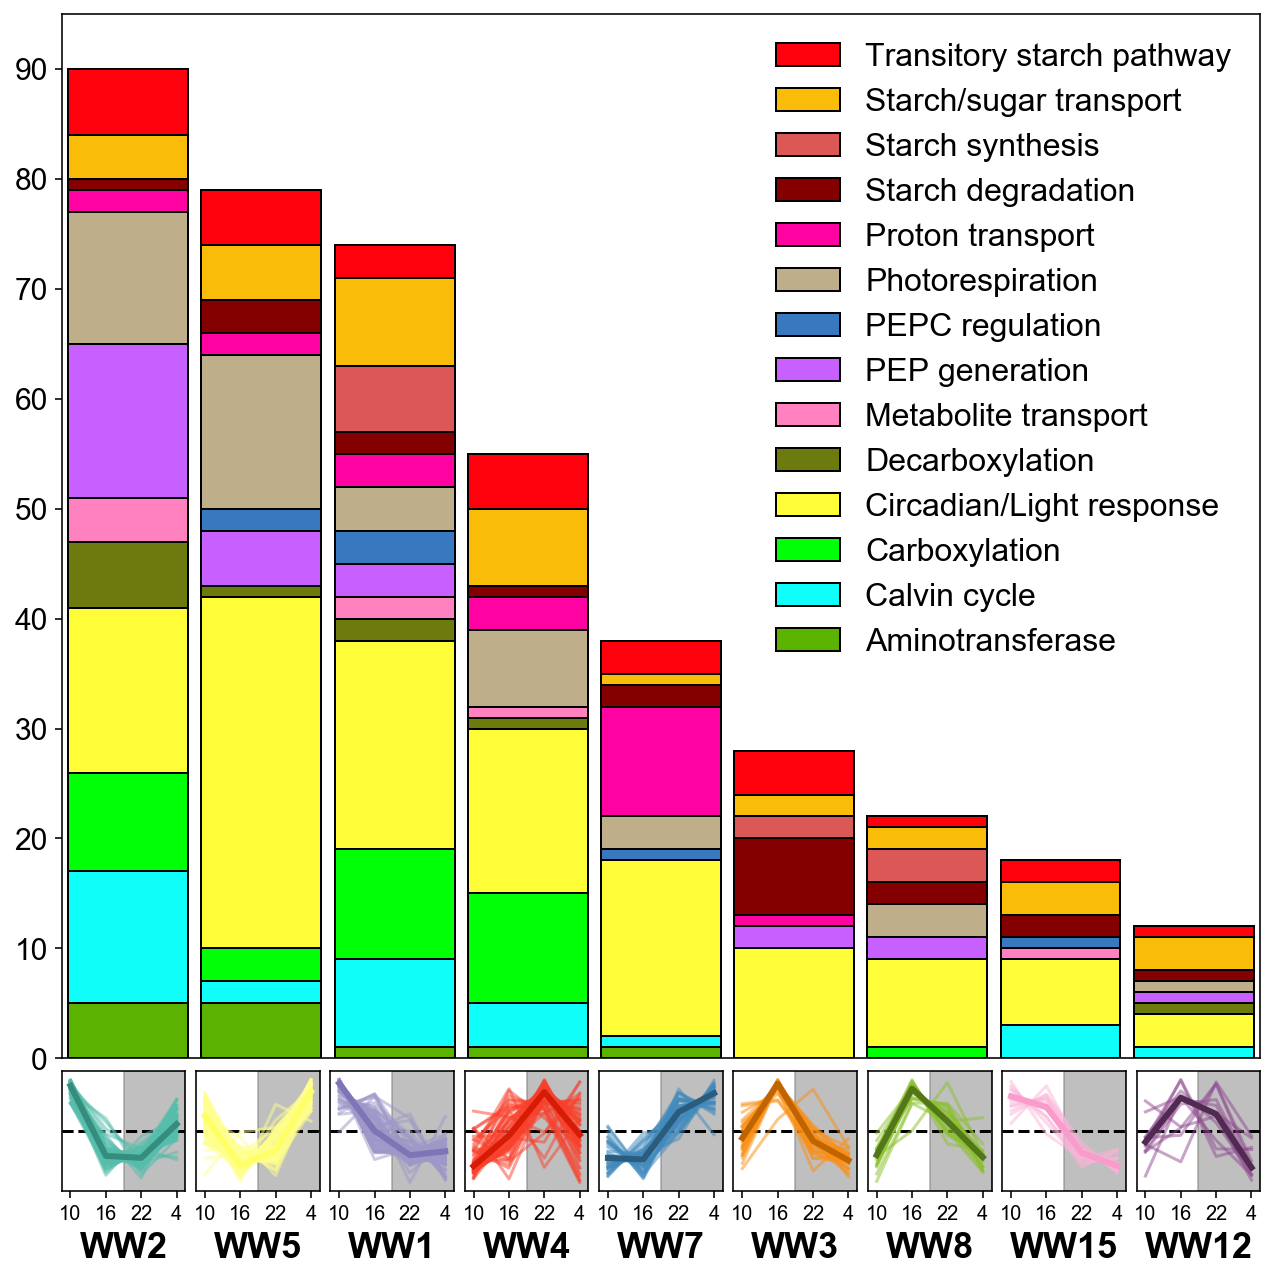

In [32]:
fig = plt.figure(constrained_layout=False, figsize=(9,9))

gs = fig.add_gridspec(nrows=9, ncols=9)
ax_w01 = fig.add_subplot(gs[8, 0])
ax_w02 = fig.add_subplot(gs[8, 1])
ax_w03 = fig.add_subplot(gs[8, 2])
ax_w04 = fig.add_subplot(gs[8, 3])
ax_w05 = fig.add_subplot(gs[8, 4])
ax_w06 = fig.add_subplot(gs[8, 5])
ax_w07 = fig.add_subplot(gs[8, 6])
ax_w08 = fig.add_subplot(gs[8, 7])
ax_w09 = fig.add_subplot(gs[8, 8])
ax_bg = fig.add_subplot(gs[0:-1, 0:])

for i, ax in enumerate(fig.get_axes()):
    ax.set_xticks([])
    ax.set_yticks([])

x=0
for i,v in pathways["WGCNA_ww"].value_counts().items():
    if v>=10:
        bottom = 0
        for k,p in pathways[pathways["WGCNA_ww"]==i]["Pathway"].value_counts(sort=False).sort_index().iteritems():
            ax_bg.bar(x=x, height=p, bottom=bottom, color = colormap[k], edgecolor="black", width=0.9, align="center")
            bottom+=p
        x+=1
        
handles = []
for i, (k,v) in enumerate(sorted(colormap.items(), reverse=True)):
    if k == "Circadian rhythm/Light response": k = "Circadian rhythm/\nLight response"
    handles.append(mpatches.Patch(color=v, label=k, ec="black"))
ax_bg.legend(handles=handles, loc="upper right", frameon=False, fontsize=16, ncol=1)

ax_bg.set_yticks(np.arange(0,100,10))
ax_bg.set_yticklabels(np.arange(0,100,10), size=15)
ax_bg.set_xlim(-0.5,8.5)
ax_bg.set_ylim(0,95)

ax = fig.get_axes()
for i,(k,c) in enumerate(WGCNA_ww_cmap.items()):
    if c == "xkcd:white":
        continue
    else:
        rect = mpatches.Rectangle(xy=(1.5, -2), width=1.75, height=4, color='grey', alpha=0.5)
        ax[i].add_patch(rect)
        ax[i].set_xlim(-0.25,3.25)
        ax[i].set_ylim(-2,2)
        
        ax[i].set_xticks([0,1,2,3])
        ax[i].set_xticklabels([10,16,22,4])
        
        subset = w_X[w_X["WGCNA_ww"]==k][[0,1,2,3]]
        for j, row in subset.iterrows():
            ax[i].plot(list(row[[0,1,2,3]]), color=lighten_color(c, 1.5), alpha=0.5)
        
        ax[i].hlines(y=0, xmin=-0.25, xmax=3.25, linestyle="--")
        ax[i].plot(subset.describe().T["50%"], lw=3, color=lighten_color(c, 2), label="Cluster {}".format(i+1),)
        ax[i].set_xlabel("WW{}".format(int(k)), size=18, weight="bold")

plt.tight_layout(w_pad=-0.15, h_pad=-0.2)
# plt.savefig("../Figures/Network-Analysis/P-oleracea-well-watered-bar-profiles.pdf", format="pdf", dpi=300, bbox_to_inches="tight")

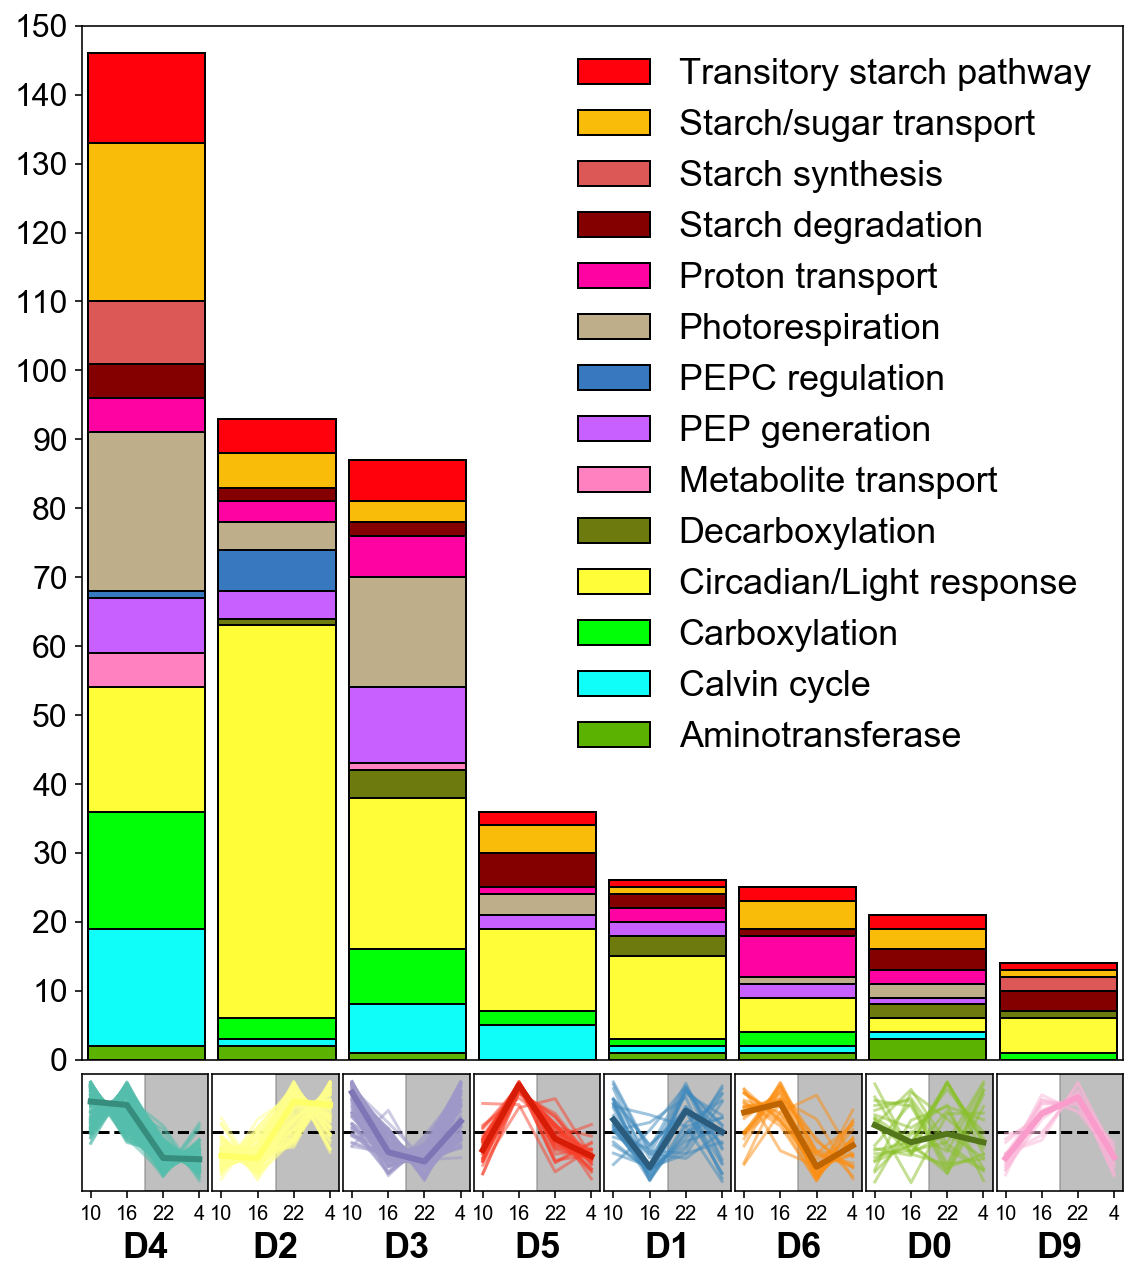

In [33]:
fig = plt.figure(constrained_layout=False, figsize=(8,9))

gs = fig.add_gridspec(nrows=9, ncols=8)
ax_d01 = fig.add_subplot(gs[8, 0])
ax_d02 = fig.add_subplot(gs[8, 1])
ax_d03 = fig.add_subplot(gs[8, 2])
ax_d04 = fig.add_subplot(gs[8, 3])
ax_d05 = fig.add_subplot(gs[8, 4])
ax_d06 = fig.add_subplot(gs[8, 5])
ax_d07 = fig.add_subplot(gs[8, 6])
ax_d08 = fig.add_subplot(gs[8, 7])
ax_bg = fig.add_subplot(gs[0:-1, 0:])

for i, ax in enumerate(fig.get_axes()):
    ax.set_xticks([])
    ax.set_yticks([])

x=0
for i,v in pathways["WGCNA_d"].value_counts().items():
    if v>=10:
        bottom = 0
        for k,p in pathways[pathways["WGCNA_d"]==i]["Pathway"].value_counts(sort=False).sort_index().iteritems():
            ax_bg.bar(x=x, height=p, bottom=bottom, color = colormap[k], edgecolor="black", width=0.9, align="center")
            bottom+=p
        x+=1

# ax_bg.grid(True, which='major', axis="both", alpha=0.5, zorder=2)
handles = []
for i, (k,v) in enumerate(sorted(colormap.items(), reverse=True)):
    if k == "Circadian rhythm/Light response": k = "Circadian rhythm/\nLight response"
    handles.append(mpatches.Patch(color=v, label=k, ec="black"))
ax_bg.legend(handles=handles, loc="upper right", frameon=False, fontsize=18, ncol=1)
ax_bg.set_yticks(np.arange(0,160,10))
ax_bg.set_yticklabels(np.arange(0,160,10), size=16)
ax_bg.set_xlim(-0.5,7.5)
ax_bg.set_ylim(0,150)

ax = fig.get_axes()
for i,(k,c) in enumerate(WGCNA_d_cmap.items()):
    if c == "xkcd:white":
        continue
    else:
        rect = mpatches.Rectangle(xy=(1.5, -2), width=1.75, height=4, color='grey', alpha=0.5)
        ax[i].add_patch(rect)
        ax[i].set_xlim(-0.25,3.25)
        ax[i].set_ylim(-2,2)
        
        ax[i].set_xticks([0,1,2,3])
        ax[i].set_xticklabels([10,16,22,4])
        
        subset = d_X[d_X["WGCNA_d"]==k][[0,1,2,3]]
        for j, row in subset.iterrows():
            ax[i].plot(list(row[[0,1,2,3]]), color=lighten_color(c, 1.5), alpha=0.5)
        
        ax[i].hlines(y=0, xmin=-0.25, xmax=3.25, linestyle="--")
        ax[i].plot(subset.describe().T["50%"], lw=3, color=lighten_color(c, 2), label="Cluster {}".format(i+1),)
        ax[i].set_xlabel("D{}".format(int(k)), size=18, weight="bold")
        
plt.tight_layout(w_pad=-0.15, h_pad=-0.2)
# plt.savefig("../Figures/Network-Analysis/P-oleracea-drought-bar-profiles.pdf", format="pdf", dpi=300, bbox_to_inches="tight")

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


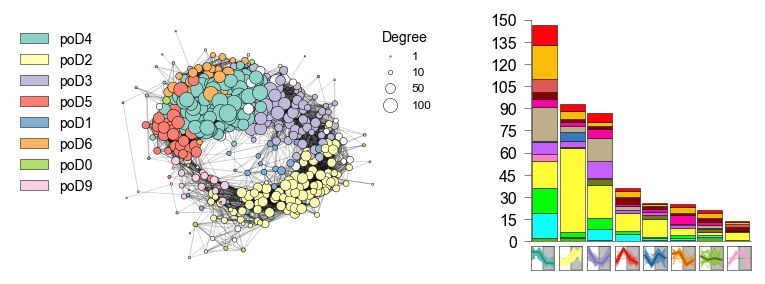

In [34]:
fig = plt.figure(constrained_layout=False, figsize=(6.75, 2.3))

gs = fig.add_gridspec(nrows=9, ncols=27)
ax_nxleg = fig.add_subplot(gs[:,0:3])
ax_nx = fig.add_subplot(gs[:,3:13])
ax_psleg = fig.add_subplot(gs[:, 13:15])
ax_d01 = fig.add_subplot(gs[8, 18])
ax_d02 = fig.add_subplot(gs[8, 19])
ax_d03 = fig.add_subplot(gs[8, 20])
ax_d04 = fig.add_subplot(gs[8, 21])
ax_d05 = fig.add_subplot(gs[8, 22])
ax_d06 = fig.add_subplot(gs[8, 23])
ax_d07 = fig.add_subplot(gs[8, 24])
ax_d08 = fig.add_subplot(gs[8, 25])
ax_bg = fig.add_subplot(gs[0:-1, 18:26])

for i, ax in enumerate(fig.get_axes()):
    ax.set_xticks([])
    ax.set_yticks([])

# Module color legend
handles = []
for i, (k,v) in enumerate(WGCNA_d_cmap.items()):
    if v == "xkcd:white": continue
    handles.append(mpatches.Patch(color=v, label="poD{}".format(int(k)), ec="black", linewidth=0.25))
ax_nxleg.legend(handles=handles, loc="upper right", frameon=False, fontsize=7, ncol=1)
ax_nxleg.axis('off')

# Point size legend
l1 = ax_psleg.scatter([],[], s=0.5*1, c="white", edgecolors='black', label="1", linewidth=0.25)
l2 = ax_psleg.scatter([],[], s=0.5*10, c="white", edgecolors='black', label="10", linewidth=0.25)
l3 = ax_psleg.scatter([],[], s=0.5*50, c="white", edgecolors='black', label="50", linewidth=0.25)
l4 = ax_psleg.scatter([],[], s=0.5*100, c="white", edgecolors='black', label="100", linewidth=0.25)
ax_psleg.legend(title="Degree", fontsize="6", frameon=False, title_fontsize=7)
ax_psleg.axis("off")

# Network plot
pos = nx.kamada_kawai_layout(dG)
WGCNA_d_cmap = {}
for idx, (i,v) in enumerate(pathways["WGCNA_d"].value_counts().items()):
    if idx == 8: idx+=1
    if v>=10: color = plt.cm.Set3(idx)
    else: color = "xkcd:white"
    WGCNA_d_cmap[i] = color

nodecolors = [WGCNA_d_cmap[pathways[pathways["transcript"]==n]["WGCNA_d"].values[0]] for n in dNodes]
ec = nx.draw_networkx_edges(dG, pos, alpha=0.25, ax=ax_nx, width=[dG[u][v]['weight'] for u,v in dG.edges()])
nc = nx.draw_networkx_nodes(dG, pos, nodelist = dNodes, node_size=[v/2 for v in d_degreedict.values()], 
                            node_color = nodecolors, ax=ax_nx, linewidths=0.25)
nc.set_edgecolor('black')
ax_nx.axis('off')

# Bar plot
x=0
for i,v in pathways["WGCNA_d"].value_counts().items():
    if v>=10:
        bottom = 0
        for k,p in pathways[pathways["WGCNA_d"]==i]["Pathway"].value_counts(sort=False).sort_index().iteritems():
            ax_bg.bar(x=x, height=p, bottom=bottom, color = colormap[k], edgecolor="black", 
                      width=0.9, align="center", linewidth=0.25)
            bottom+=p
        x+=1
ax_bg.tick_params(axis="y", which='both', width=0.25)        
ax_bg.set_yticks(np.arange(0,165,15))
ax_bg.set_yticklabels(np.arange(0,165,15), size=8)
ax_bg.set_xlim(-0.5,7.5)
ax_bg.set_ylim(0,150)
for a in ['bottom','left']: ax_bg.spines[a].set_linewidth(0.25)
for a in ['top','right']: ax_bg.spines[a].set_linewidth(0)
    
# Z-score plots
for ax,(k,c) in zip([ax_d01,ax_d02,ax_d03,ax_d04,ax_d05,ax_d06,ax_d07,ax_d08],WGCNA_d_cmap.items()):
    if c == "xkcd:white":
        continue
    else:
        rect = mpatches.Rectangle(xy=(1.5, -2), width=1.75, height=4, color='grey', alpha=0.5)
        ax.add_patch(rect)
        ax.set_xlim(-0.25,3.25)
        ax.set_ylim(-2,2)
        
        ax.tick_params(axis="x", which='both', length=0, width=0)
        ax.set_xticks([0,1,2,3])
        ax.set_xticklabels([])
        
        for a in ['top','bottom','left','right']: ax.spines[a].set_linewidth(0.25)
        
        subset = d_X[d_X["WGCNA_d"]==k][[0,1,2,3]]
        for j, row in subset.iterrows():
            ax.plot(list(row[[0,1,2,3]]), color=lighten_color(c, 1.5), alpha=0.5, linewidth=0.5)
        
        ax.hlines(y=0, xmin=-0.25, xmax=3.25, linestyle="dotted", linewidths=0.25)
        ax.plot(subset.describe().T["50%"], lw=1, color=lighten_color(c, 2))
        
plt.tight_layout(w_pad=-0.15, h_pad=-0.2)
# plt.savefig("../Figures/Network-Analysis/P-oleracea-D-Fig3-panel.pdf", format="pdf", dpi=300, bbox_to_inches="tight")

In [57]:
suppPathways = pd.read_csv("../InDepth-Annotation-Pipeline/P-oleracea-pathway-assignments.csv")
amilisSupp = pd.read_csv("../Submission-files/MBE/Supplementary-data-S1.csv")
sleuthDE = pd.read_csv("../Abundance-analysis/sleuth/P-oleracea-sleuth-DEgenes.csv")
suppPathways = suppPathways.merge(sleuthDE[["target_id", "qval"]], left_on="transcript", right_on="target_id", how='left').drop(labels=["target_id"], axis=1)
suppPathways = suppPathways.merge(wwModAssgn, on="transcript", how="left")
# suppPathways = suppPathways.drop(labels=["Notes"], axis=1)
to_replace = ["Circadian rhythm", "Circadian rhythm/Light response", "Light response"]
suppPathways["Pathway"] = [p if p not in to_replace else "Circadian/Light response" for p in suppPathways.Pathway.values]

uniprots = []
for i,row in suppPathways.iterrows():
    if row["Pamilis-uniprot"]=="":
        uniprots.append("po."+row["Poleracea-uniprot"])
    else:
        uniprots.append(row["Pamilis-uniprot"])
suppPathways["Uniprot"] = uniprots

suppPathways = suppPathways.merge(amilisSupp[["Orthogroup", "genemodel", "Localization", "Arabidopsis ortholog"]], left_on="Pamilis-ortholog", right_on="genemodel", how='left')
suppPathways = suppPathways.drop(labels=["Pamilis-uniprot", "Athaliana-uniprot", "Poleracea-uniprot", "Athaliana-ortholog", "Orthogroup_x", "Localization_x", "genemodel"], axis=1)
suppPathways = suppPathways.rename({"Orthogroup_y":"Orthogroup", "Localization_y":"Localization", "Arabidopsis ortholog":"Arabidopsis-ortholog", "Uniprot":"Label"}, axis=1)

suppPathways

transcript Pamilis-ortholog Gene-family  \
0    TRINITY_DN103395_c0_g1       FUN_048323         ADK   
1      TRINITY_DN1529_c0_g1       FUN_046898         ADK   
2      TRINITY_DN1795_c0_g4       FUN_048323         ADK   
3     TRINITY_DN18870_c0_g1       FUN_011473         ADK   
4       TRINITY_DN954_c0_g1       FUN_026031         ADK   
..                      ...              ...         ...   
620    TRINITY_DN6298_c1_g2       FUN_013944         VHA   
621    TRINITY_DN7459_c1_g1       FUN_052554         VHA   
622    TRINITY_DN8966_c0_g1       FUN_030915         VHA   
623    TRINITY_DN9290_c0_g1       FUN_005480         VHA   
624    TRINITY_DN7780_c0_g1       FUN_047817         XPT   

                               Block-description                 Pathway  \
0                             Adenylate kinase 2          PEP generation   
1                             Adenylate kinase 3          PEP generation   
2                             Adenylate kinase 2          PEP generation   
3                             Adenylate kinase 3          PEP generation   
4                             Adenylate kinase 5          PEP generation   
..                                           ...                     ...   
620     V-type proton ATPase catalytic subunit C        Proton transport   
621     V-type proton ATPase catalytic subunit H        Proton transport   
622     V-type proton ATPase catalytic subunit d        Proton transport   
623    V-type proton ATPase catalytic subunit a1        Proton transport   
624  Xylulose 5-phosphate/phosphate translocator  Starch/sugar transport   

             qval  WGCNA_ww  WGCNA_d     Label Orthogroup Localization  \
0    1.555245e-02       2.0      3.0    ADK2-1  OG0011322  chloroplast   
1    1.774988e-03      12.0      3.0    ADK3-1  OG0002519  chloroplast   
2    4.586998e-02       2.0      3.0    ADK2-1  OG0011322  chloroplast   
3    1.779659e-07       1.0      6.0    ADK3-2  OG0002519  chloroplast   
4    5.351087e-05       5.0      4.0    ADK5-1  OG0006840  chloroplast   
..            ...       ...      ...       ...        ...          ...   
620  2.426764e-03      11.0      3.0   VHA-C-1  OG0006127      vacuole   
621  1.135199e-10       2.0      2.0   VHA-H-2  OG0005190      vacuole   
622  2.189547e-05      25.0      4.0   VHA-d-1  OG0003913      vacuole   
623  9.115518e-04       3.0      1.0  VHA-a1-1  OG0003367      vacuole   
624  7.224643e-05       4.0      6.0     XPT-1  OG0015365  chloroplast   

     Arabidopsis-ortholog  
0               AT5G47840  
1    AT5G50370, AT5G63400  
2               AT5G47840  
3    AT5G50370, AT5G63400  
4               AT5G35170  
..                    ...  
620             AT1G12840  
621             AT3G42050  
622  AT3G28710, AT3G28715  
623             AT2G28520  
624             AT5G17630  

[625 rows x 12 columns]

In [56]:
suppPathways.to_csv("../Submission-files/MBE/Supplementary-data-S2.csv", index=False)

In [50]:
suppPathways = suppPathways.merge(amilisSupp[["Orthogroup", "genemodel", "Localization"]], left_on="Pamilis-ortholog", right_on="genemodel", how='left')
suppPathways = suppPathways.drop(labels=["Orthogroup_x", "Localization_x"], axis=1)
suppPathways = suppPathways.rename({"Orthogroup_y":"Orthogroup", "Localization_y":"Localization"}, axis=1)
suppPathways

transcript Athaliana-ortholog Pamilis-ortholog Gene-family  \
0    TRINITY_DN103395_c0_g1                NaN       FUN_048323         ADK   
1      TRINITY_DN1529_c0_g1                NaN       FUN_046898         ADK   
2      TRINITY_DN1795_c0_g4                NaN       FUN_048323         ADK   
3     TRINITY_DN18870_c0_g1                NaN       FUN_011473         ADK   
4       TRINITY_DN954_c0_g1                NaN       FUN_026031         ADK   
..                      ...                ...              ...         ...   
620    TRINITY_DN6298_c1_g2                NaN       FUN_013944         VHA   
621    TRINITY_DN7459_c1_g1                NaN       FUN_052554         VHA   
622    TRINITY_DN8966_c0_g1                NaN       FUN_030915         VHA   
623    TRINITY_DN9290_c0_g1                NaN       FUN_005480         VHA   
624    TRINITY_DN7780_c0_g1                NaN       FUN_047817         XPT   

                               Block-description                 Pathway  \
0                             Adenylate kinase 2          PEP generation   
1                             Adenylate kinase 3          PEP generation   
2                             Adenylate kinase 2          PEP generation   
3                             Adenylate kinase 3          PEP generation   
4                             Adenylate kinase 5          PEP generation   
..                                           ...                     ...   
620     V-type proton ATPase catalytic subunit C        Proton transport   
621     V-type proton ATPase catalytic subunit H        Proton transport   
622     V-type proton ATPase catalytic subunit d        Proton transport   
623    V-type proton ATPase catalytic subunit a1        Proton transport   
624  Xylulose 5-phosphate/phosphate translocator  Starch/sugar transport   

             qval  WGCNA_ww  WGCNA_d   Uniprot Orthogroup_y   genemodel  \
0    1.555245e-02       2.0      3.0    ADK2-1    OG0011322  FUN_048323   
1    1.774988e-03      12.0      3.0    ADK3-1    OG0002519  FUN_046898   
2    4.586998e-02       2.0      3.0    ADK2-1    OG0011322  FUN_048323   
3    1.779659e-07       1.0      6.0    ADK3-2    OG0002519  FUN_011473   
4    5.351087e-05       5.0      4.0    ADK5-1    OG0006840  FUN_026031   
..            ...       ...      ...       ...          ...         ...   
620  2.426764e-03      11.0      3.0   VHA-C-1    OG0006127  FUN_013944   
621  1.135199e-10       2.0      2.0   VHA-H-2    OG0005190  FUN_052554   
622  2.189547e-05      25.0      4.0   VHA-d-1    OG0003913  FUN_030915   
623  9.115518e-04       3.0      1.0  VHA-a1-1    OG0003367  FUN_005480   
624  7.224643e-05       4.0      6.0     XPT-1    OG0015365  FUN_047817   

    Localization_y  
0      chloroplast  
1      chloroplast  
2      chloroplast  
3      chloroplast  
4      chloroplast  
..             ...  
620        vacuole  
621        vacuole  
622        vacuole  
623        vacuole  
624    chloroplast  

[625 rows x 13 columns]